In [2]:
import os
import copy
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from torchvision.models import alexnet, AlexNet_Weights

from sklearn.metrics import f1_score, classification_report

import lightning as L
from lightning import Fabric

from src.models import AlexNetWithSilu
from src.resnet_modifications import resnet18

In [2]:
DATA_DIR = 'data/img_align_celeba/img_align_celeba/'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
torch.set_float32_matmul_precision('high')

# EDA

In [4]:
ys = pd.read_csv('data/list_attr_celeba.csv')

In [5]:
ys.head(5)

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [6]:
ys.columns

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')

In [7]:
for column in ys.columns[1:]:
    print(ys[column].value_counts())

5_o_Clock_Shadow
-1    180083
 1     22516
Name: count, dtype: int64
Arched_Eyebrows
-1    148509
 1     54090
Name: count, dtype: int64
Attractive
 1    103833
-1     98766
Name: count, dtype: int64
Bags_Under_Eyes
-1    161153
 1     41446
Name: count, dtype: int64
Bald
-1    198052
 1      4547
Name: count, dtype: int64
Bangs
-1    171890
 1     30709
Name: count, dtype: int64
Big_Lips
-1    153814
 1     48785
Name: count, dtype: int64
Big_Nose
-1    155083
 1     47516
Name: count, dtype: int64
Black_Hair
-1    154127
 1     48472
Name: count, dtype: int64
Blond_Hair
-1    172616
 1     29983
Name: count, dtype: int64
Blurry
-1    192287
 1     10312
Name: count, dtype: int64
Brown_Hair
-1    161027
 1     41572
Name: count, dtype: int64
Bushy_Eyebrows
-1    173796
 1     28803
Name: count, dtype: int64
Chubby
-1    190936
 1     11663
Name: count, dtype: int64
Double_Chin
-1    193140
 1      9459
Name: count, dtype: int64
Eyeglasses
-1    189406
 1     13193
Name: count, dtype: 

In [8]:
ys['Smiling'].value_counts()

Smiling
-1    104930
 1     97669
Name: count, dtype: int64

In [9]:
ys['Heavy_Makeup'].value_counts()

Heavy_Makeup
-1    124209
 1     78390
Name: count, dtype: int64

In [10]:
split = pd.read_csv('data/list_eval_partition.csv')

In [11]:
split['partition'].value_counts()

partition
0    162770
2     19962
1     19867
Name: count, dtype: int64

In [12]:
X_train = split[split['partition'] == 0].image_id.values
y_train = ys[ys['image_id'].isin(X_train)]['Heavy_Makeup'].values
y_train = np.where(y_train == -1, 0, 1)

X_val = split[split['partition'] == 1].image_id.values
y_val = ys[ys['image_id'].isin(X_val)]['Heavy_Makeup'].values
y_val = np.where(y_val == -1, 0, 1)

X_test = split[split['partition'] == 2].image_id.values
y_test = ys[ys['image_id'].isin(X_test)]['Heavy_Makeup'].values
y_test = np.where(y_test == -1, 0, 1)

In [40]:
def plow_sample(transform=None):
    sample = np.random.choice(ys['image_id'].values, size=16)
    fig, axs = plt.subplots(4, 4, figsize=(8, 8))
    for i in range(4):
        for j in range(4):
            image_path = sample[i * 4 + j]
            label = float(ys[ys['image_id'] == image_path]['Heavy_Makeup'].values[0])
    
            image = Image.open(f'data/img_align_celeba/img_align_celeba/{image_path}').convert('RGB')
            if transform is not None:
                image = transform(image)
            image_numpy = np.array(image).squeeze()
            # print(image_numpy[0].shape)
            
            axs[i, j].imshow(image_numpy, cmap='gray')
            axs[i, j].axis('off')
            axs[i, j].set_title(f"Label: {1 if label > 0 else 0}")
    
    plt.tight_layout()
    plt.show()

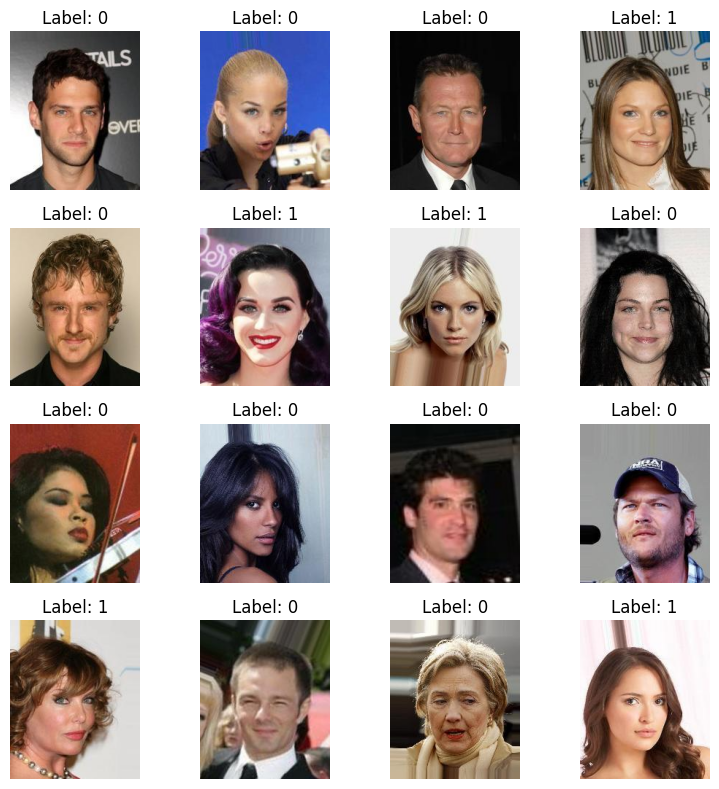

In [19]:
plow_sample()

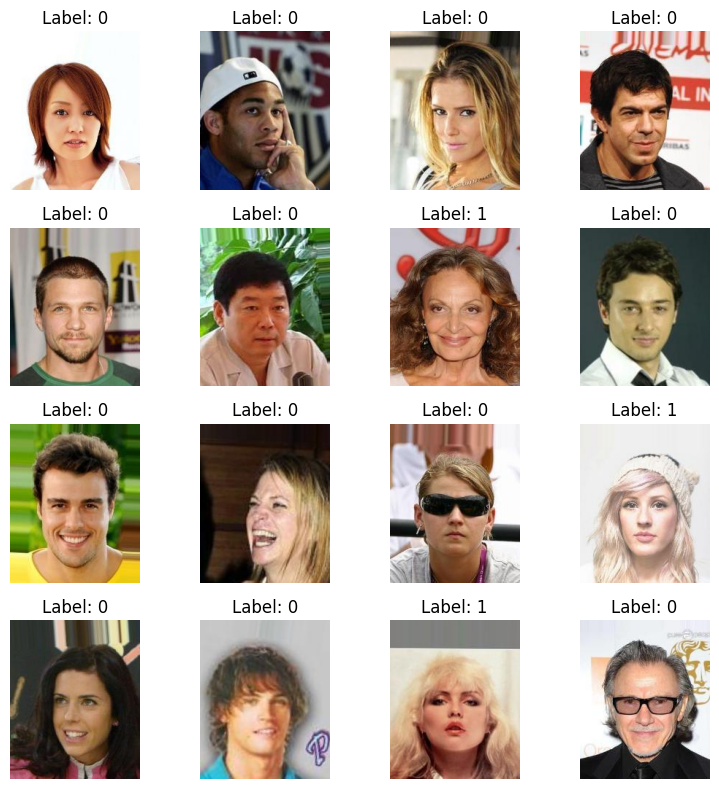

In [18]:
plow_sample()

In [15]:
train_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    # transforms.ToTensor(),
    # transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

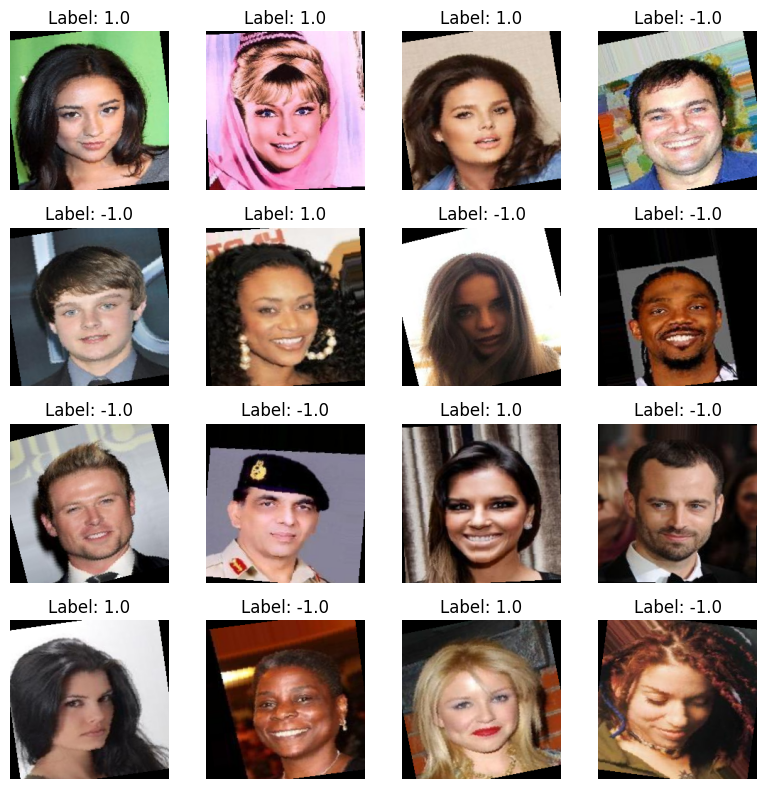

In [16]:
plow_sample(train_tfms)

# Learn

In [13]:
class MakeupDataset(Dataset):
    def __init__(self, image_ids, labels, root_dir, transform=None):
        self.ids = image_ids
        self.labels = labels
        self.root = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        path = os.path.join(self.root, img_id)
        img = Image.open(path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label

# class MakeupDataset(Dataset):
#     def __init__(self, image_ids, labels, root_dir, transform=None):
#         self.labels = labels.astype(np.int64)
#         self.transform = transform
#         self.data = []

#         # 1) Считываем все изображения заранее
#         for img_id in tqdm(image_ids, desc="Preloading images"):
#             path = os.path.join(root_dir, img_id)
#             img = Image.open(path).convert('RGB')
#             if self.transform:
#                 img = self.transform(img)
#             # img теперь — torch.Tensor [C, H, W]
#             self.data.append(img)

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         return self.data[idx], self.labels[idx]

In [14]:
train_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    # transforms.ColorJitter(0.2,0.2,0.2,0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
val_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [15]:
def train_one_epoch(epoch, current_model):
    current_model.train()
    running_loss = 0.0
    all_preds, all_targets = [], []

    for imgs, targets in tqdm(train_loader, desc=f"Train {epoch}"):
        imgs, targets = imgs.to(DEVICE), targets.float().to(DEVICE)
        optimizer.zero_grad()
        outputs = current_model(imgs).squeeze(1)
        loss = criterion(outputs, targets)
        
        # loss.backward()
        fabric.backward(loss)
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds = torch.sigmoid(outputs).detach().cpu().numpy() > 0.5
        all_preds.extend(preds.astype(int))
        all_targets.extend(targets.cpu().numpy().astype(int))

    epoch_loss = running_loss / len(train_ds)
    epoch_f1 = f1_score(all_targets, all_preds)
    return epoch_loss, epoch_f1

def eval_model(loader, current_model, split_name):
    current_model.eval()
    running_loss = 0.0
    all_preds, all_targets = [], []

    with torch.no_grad():
        for imgs, targets in loader:
            imgs, targets = imgs.to(DEVICE), targets.float().to(DEVICE)
            outputs = current_model(imgs).squeeze(1)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * imgs.size(0)
            preds = torch.sigmoid(outputs).cpu().numpy() > 0.5
            all_preds.extend(preds.astype(int))
            all_targets.extend(targets.cpu().numpy().astype(int))

    loss = running_loss / len(loader.dataset)
    f1 = f1_score(all_targets, all_preds)
    print(f"{split_name} — Loss: {loss:.4f}, F1: {f1:.4f}")
    return loss, f1, all_targets, all_preds


# AlexNet

## AlexNet Vanilla

In [27]:
BATCH_SIZE = 32
NUM_EPOCHS = 20

In [32]:
train_ds = MakeupDataset(X_train, y_train, DATA_DIR, transform=train_tfms)
val_ds   = MakeupDataset(X_val,   y_val,   DATA_DIR, transform=val_tfms)
test_ds  = MakeupDataset(X_test,  y_test,  DATA_DIR, transform=val_tfms)

# train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=6)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=6)

val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=6)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=6)

In [33]:
fabric = Fabric(accelerator=DEVICE, devices=1, precision="bf16-true")
# fabric = Fabric(accelerator="cuda", devices=1, precision="16-mixed")

fabric.launch()
train_loader, test_loader = fabric.setup_dataloaders(train_loader, test_loader)
criterion = nn.BCEWithLogitsLoss()

In [36]:
LR = 0.0001

BEST_MODEL_PATH = 'models/best_alexnet.pth'

# weight = AlexNet_Weights.IMAGENET1K_V1
# model = models.alexnet(weights=weight)
model = models.alexnet()
model.classifier[6] = nn.Linear(4096, 1) 
model = model.to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR)

model, optimizer = fabric.setup(model, optimizer)

In [38]:
best_f1 = 0.0
history = {'train_loss':[], 'train_f1':[], 'val_loss':[], 'val_f1':[]}

try:
    for epoch in range(1, 10):
        tr_loss, tr_f1 = train_one_epoch(epoch, model)
        val_loss, val_f1, _, _ = eval_model(val_loader, model, 'Validation')
    
        history['train_loss'].append(tr_loss)
        history['train_f1'].append(tr_f1)
        history['val_loss'].append(val_loss)
        history['val_f1'].append(val_f1)
    
        # Сохранение лучшей модели
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, BEST_MODEL_PATH)
            print(f">>> New best model saved (F1={best_f1:.4f})")
except KeyboardInterrupt:
    pass

Train 1: 100%|██████████████████████████████| 5087/5087 [02:00<00:00, 42.26it/s]


Validation — Loss: 0.2015, F1: 0.8883
>>> New best model saved (F1=0.8883)


Train 2: 100%|██████████████████████████████| 5087/5087 [02:00<00:00, 42.13it/s]


Validation — Loss: 0.1997, F1: 0.8880


Train 3: 100%|██████████████████████████████| 5087/5087 [02:00<00:00, 42.23it/s]


Validation — Loss: 0.1995, F1: 0.8848


Train 4: 100%|██████████████████████████████| 5087/5087 [02:00<00:00, 42.12it/s]


Validation — Loss: 0.1980, F1: 0.8867


Train 5: 100%|██████████████████████████████| 5087/5087 [02:00<00:00, 42.12it/s]


Validation — Loss: 0.1948, F1: 0.8894
>>> New best model saved (F1=0.8894)


Train 6: 100%|██████████████████████████████| 5087/5087 [02:00<00:00, 42.28it/s]


Validation — Loss: 0.1973, F1: 0.8896
>>> New best model saved (F1=0.8896)


Train 7: 100%|██████████████████████████████| 5087/5087 [02:00<00:00, 42.25it/s]


Validation — Loss: 0.1970, F1: 0.8904
>>> New best model saved (F1=0.8904)


Train 8: 100%|██████████████████████████████| 5087/5087 [02:00<00:00, 42.13it/s]


Validation — Loss: 0.1941, F1: 0.8899


Train 9: 100%|██████████████████████████████| 5087/5087 [02:01<00:00, 42.00it/s]


Validation — Loss: 0.1928, F1: 0.8903


In [39]:
print("\n=== Testing on best model ===")
model.load_state_dict(torch.load(BEST_MODEL_PATH))
test_loss, test_f1, y_true, y_pred = eval_model(test_loader, model, 'Test')
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))


=== Testing on best model ===
Test — Loss: 0.2193, F1: 0.8858

Classification Report:
               precision    recall  f1-score   support

           0     0.9410    0.8952    0.9175     11878
           1     0.8563    0.9175    0.8858      8084

    accuracy                         0.9042     19962
   macro avg     0.8986    0.9063    0.9017     19962
weighted avg     0.9067    0.9042    0.9047     19962



## Alexnet + Other Batch Size

In [41]:
BATCH_SIZE = 128
NUM_EPOCHS = 20

In [42]:
train_ds = MakeupDataset(X_train, y_train, DATA_DIR, transform=train_tfms)
val_ds   = MakeupDataset(X_val,   y_val,   DATA_DIR, transform=val_tfms)
test_ds  = MakeupDataset(X_test,  y_test,  DATA_DIR, transform=val_tfms)

# train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=6)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=6)

val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=6)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=6)

In [ ]:
fabric = Fabric(accelerator=DEVICE, devices=1, precision="bf16-true")
# fabric = Fabric(accelerator="cuda", devices=1, precision="16-mixed")

fabric.launch()
train_loader, test_loader = fabric.setup_dataloaders(train_loader, test_loader)
criterion = nn.BCEWithLogitsLoss()

In [43]:
LR = 0.0001

BEST_MODEL_PATH = 'models/best_alexnet_other_batch.pth'

# weight = AlexNet_Weights.IMAGENET1K_V1
# model = models.alexnet(weights=weight)
model = models.alexnet()
model.classifier[6] = nn.Linear(4096, 1) 
model = model.to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR)

model, optimizer = fabric.setup(model, optimizer)

In [45]:
best_f1 = 0.0
history = {'train_loss':[], 'train_f1':[], 'val_loss':[], 'val_f1':[]}

try:
    for epoch in range(1, 10):
        tr_loss, tr_f1 = train_one_epoch(epoch, model)
        val_loss, val_f1, _, _ = eval_model(val_loader, model, 'Validation')
    
        history['train_loss'].append(tr_loss)
        history['train_f1'].append(tr_f1)
        history['val_loss'].append(val_loss)
        history['val_f1'].append(val_f1)
    
        # Сохранение лучшей модели
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, BEST_MODEL_PATH)
            print(f">>> New best model saved (F1={best_f1:.4f})")
except KeyboardInterrupt:
    pass

Train 1: 100%|██████████████████████████████| 1272/1272 [01:25<00:00, 14.82it/s]


Validation — Loss: 0.2066, F1: 0.8855
>>> New best model saved (F1=0.8855)


Train 2: 100%|██████████████████████████████| 1272/1272 [01:25<00:00, 14.82it/s]


Validation — Loss: 0.2035, F1: 0.8843


Train 3: 100%|██████████████████████████████| 1272/1272 [01:26<00:00, 14.76it/s]


Validation — Loss: 0.2004, F1: 0.8857
>>> New best model saved (F1=0.8857)


Train 4: 100%|██████████████████████████████| 1272/1272 [01:26<00:00, 14.78it/s]


Validation — Loss: 0.1991, F1: 0.8900
>>> New best model saved (F1=0.8900)


Train 5: 100%|██████████████████████████████| 1272/1272 [01:26<00:00, 14.79it/s]


Validation — Loss: 0.1975, F1: 0.8905
>>> New best model saved (F1=0.8905)


Train 6: 100%|██████████████████████████████| 1272/1272 [01:26<00:00, 14.70it/s]


Validation — Loss: 0.2102, F1: 0.8744


Train 7: 100%|██████████████████████████████| 1272/1272 [01:26<00:00, 14.71it/s]


Validation — Loss: 0.1928, F1: 0.8940
>>> New best model saved (F1=0.8940)


Train 8: 100%|██████████████████████████████| 1272/1272 [01:26<00:00, 14.76it/s]


Validation — Loss: 0.1915, F1: 0.8896


Train 9: 100%|██████████████████████████████| 1272/1272 [01:26<00:00, 14.78it/s]


Validation — Loss: 0.1948, F1: 0.8913


In [46]:
print("\n=== Testing on best model ===")
model.load_state_dict(torch.load(BEST_MODEL_PATH))
test_loss, test_f1, y_true, y_pred = eval_model(test_loader, model, 'Test')
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))


=== Testing on best model ===
Test — Loss: 0.2110, F1: 0.8881

Classification Report:
               precision    recall  f1-score   support

           0     0.9361    0.9058    0.9207     11878
           1     0.8679    0.9092    0.8881      8084

    accuracy                         0.9072     19962
   macro avg     0.9020    0.9075    0.9044     19962
weighted avg     0.9085    0.9072    0.9075     19962



## Alexnet + WeightedRandomSampler

In [12]:
BATCH_SIZE = 256
NUM_EPOCHS = 20

In [22]:
class_sample_count = np.bincount(y_train)
weights = 1. / class_sample_count
samples_weight = weights[y_train]
sampler = WeightedRandomSampler(samples_weight, num_samples=len(samples_weight), replacement=True)


In [23]:
train_ds = MakeupDataset(X_train, y_train, DATA_DIR, transform=train_tfms)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=6)

In [24]:
train_loader, test_loader = fabric.setup_dataloaders(train_loader, test_loader)

In [25]:
LR = 0.0001

BEST_MODEL_PATH = 'models/best_alexnet_weighted.pth'

# weight = AlexNet_Weights.IMAGENET1K_V1
# model = models.alexnet(weights=weight)
model = models.alexnet()
model.classifier[6] = nn.Linear(4096, 1) 
model = model.to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR)

model, optimizer = fabric.setup(model, optimizer)

In [26]:
best_f1 = 0.0
history = {'train_loss':[], 'train_f1':[], 'val_loss':[], 'val_f1':[]}

try:
    for epoch in range(1, 10):
        tr_loss, tr_f1 = train_one_epoch(epoch, model)
        val_loss, val_f1, _, _ = eval_model(val_loader, model, 'Validation')
    
        history['train_loss'].append(tr_loss)
        history['train_f1'].append(tr_f1)
        history['val_loss'].append(val_loss)
        history['val_f1'].append(val_f1)
    
        # Сохранение лучшей модели
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, BEST_MODEL_PATH)
            print(f">>> New best model saved (F1={best_f1:.4f})")
except KeyboardInterrupt:
    pass

Train 1: 100%|████████████████████████████████| 636/636 [01:18<00:00,  8.06it/s]


Validation — Loss: 0.2300, F1: 0.8762
>>> New best model saved (F1=0.8762)


Train 2: 100%|████████████████████████████████| 636/636 [01:18<00:00,  8.07it/s]


Validation — Loss: 0.2111, F1: 0.8846
>>> New best model saved (F1=0.8846)


Train 3: 100%|████████████████████████████████| 636/636 [01:18<00:00,  8.06it/s]


Validation — Loss: 0.2063, F1: 0.8866
>>> New best model saved (F1=0.8866)


Train 4: 100%|████████████████████████████████| 636/636 [01:18<00:00,  8.06it/s]


Validation — Loss: 0.2011, F1: 0.8877
>>> New best model saved (F1=0.8877)


Train 5: 100%|████████████████████████████████| 636/636 [01:18<00:00,  8.05it/s]


Validation — Loss: 0.2257, F1: 0.8790


Train 6: 100%|████████████████████████████████| 636/636 [01:18<00:00,  8.05it/s]


Validation — Loss: 0.2082, F1: 0.8876


Train 7: 100%|████████████████████████████████| 636/636 [01:19<00:00,  8.00it/s]


Validation — Loss: 0.1969, F1: 0.8896
>>> New best model saved (F1=0.8896)


Train 8: 100%|████████████████████████████████| 636/636 [01:19<00:00,  8.03it/s]


Validation — Loss: 0.2002, F1: 0.8905
>>> New best model saved (F1=0.8905)


Train 9: 100%|████████████████████████████████| 636/636 [01:19<00:00,  8.01it/s]


Validation — Loss: 0.1982, F1: 0.8892


In [27]:
print("\n=== Testing on best model ===")
model.load_state_dict(torch.load(BEST_MODEL_PATH))
test_loss, test_f1, y_true, y_pred = eval_model(test_loader, model, 'Test')
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))


=== Testing on best model ===
Test — Loss: 0.2253, F1: 0.8828

Classification Report:
               precision    recall  f1-score   support

           0     0.9511    0.8763    0.9122     11878
           1     0.8371    0.9338    0.8828      8084

    accuracy                         0.8996     19962
   macro avg     0.8941    0.9051    0.8975     19962
weighted avg     0.9049    0.8996    0.9003     19962



## AlexNet + scheduler

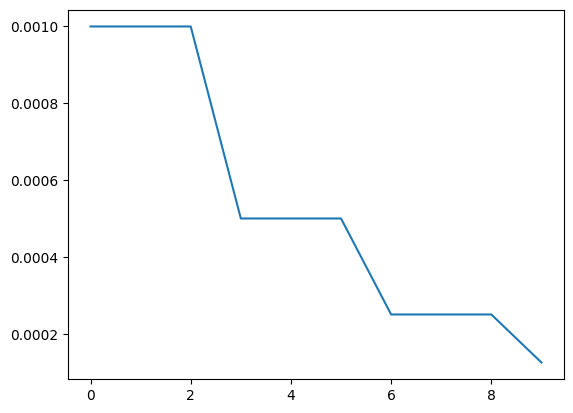

In [10]:
model = torch.nn.Linear(2, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
lrs = []

for i in range(10):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()

plt.plot(range(10),lrs)

In [11]:
BATCH_SIZE = 256
NUM_EPOCHS = 20

In [12]:
train_ds = MakeupDataset(X_train, y_train, DATA_DIR, transform=train_tfms)
val_ds   = MakeupDataset(X_val,   y_val,   DATA_DIR, transform=val_tfms)
test_ds  = MakeupDataset(X_test,  y_test,  DATA_DIR, transform=val_tfms)

# train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=6)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=6)

val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=6)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=6)

In [14]:
fabric = Fabric(accelerator='cuda', devices=1, precision="bf16-true")
# fabric = Fabric(accelerator="cuda", devices=1, precision="16-mixed")

fabric.launch()
train_loader, test_loader = fabric.setup_dataloaders(train_loader, test_loader)
criterion = nn.BCEWithLogitsLoss()

In [15]:
LR = 0.0001

BEST_MODEL_PATH = 'models/best_alexnet_sheduller.pth'

# weight = AlexNet_Weights.IMAGENET1K_V1
# model = models.alexnet(weights=weight)
model = models.alexnet()
model.classifier[6] = nn.Linear(4096, 1) 
model = model.to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

model, optimizer = fabric.setup(model, optimizer)

In [16]:
best_f1 = 0.0
history = {'train_loss':[], 'train_f1':[], 'val_loss':[], 'val_f1':[]}

try:
    for epoch in range(1, 10):
        tr_loss, tr_f1 = train_one_epoch(epoch, model)
        scheduler.step()
        
        val_loss, val_f1, _, _ = eval_model(val_loader, model, 'Validation')
        
        history['train_loss'].append(tr_loss)
        history['train_f1'].append(tr_f1)
        history['val_loss'].append(val_loss)
        history['val_f1'].append(val_f1)
    
        # Сохранение лучшей модели
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, BEST_MODEL_PATH)
            print(f">>> New best model saved (F1={best_f1:.4f})")
except KeyboardInterrupt:
    pass

Train 1: 100%|████████████████████████████████| 636/636 [01:18<00:00,  8.05it/s]


Validation — Loss: 0.2270, F1: 0.8742
>>> New best model saved (F1=0.8742)


Train 2: 100%|████████████████████████████████| 636/636 [01:18<00:00,  8.10it/s]


Validation — Loss: 0.2083, F1: 0.8850
>>> New best model saved (F1=0.8850)


Train 3: 100%|████████████████████████████████| 636/636 [01:18<00:00,  8.05it/s]


Validation — Loss: 0.2008, F1: 0.8841


Train 4: 100%|████████████████████████████████| 636/636 [01:18<00:00,  8.05it/s]


Validation — Loss: 0.1985, F1: 0.8881
>>> New best model saved (F1=0.8881)


Train 5: 100%|████████████████████████████████| 636/636 [01:19<00:00,  8.03it/s]


Validation — Loss: 0.1964, F1: 0.8900
>>> New best model saved (F1=0.8900)


Train 6: 100%|████████████████████████████████| 636/636 [01:17<00:00,  8.21it/s]


Validation — Loss: 0.1994, F1: 0.8843


Train 7: 100%|████████████████████████████████| 636/636 [01:17<00:00,  8.16it/s]


Validation — Loss: 0.1944, F1: 0.8907
>>> New best model saved (F1=0.8907)


Train 8: 100%|████████████████████████████████| 636/636 [01:19<00:00,  8.03it/s]


Validation — Loss: 0.1943, F1: 0.8897


Train 9: 100%|████████████████████████████████| 636/636 [01:18<00:00,  8.06it/s]


Validation — Loss: 0.1944, F1: 0.8904


In [18]:
print("\n=== Testing on best model ===")
model.load_state_dict(torch.load(BEST_MODEL_PATH))
test_loss, test_f1, y_true, y_pred = eval_model(test_loader, model, 'Test')
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))


=== Testing on best model ===
Test — Loss: 0.2171, F1: 0.8833

Classification Report:
               precision    recall  f1-score   support

           0     0.9253    0.9134    0.9193     11878
           1     0.8751    0.8916    0.8833      8084

    accuracy                         0.9046     19962
   macro avg     0.9002    0.9025    0.9013     19962
weighted avg     0.9050    0.9046    0.9047     19962



## All in one

In [37]:
BATCH_SIZE = 128
NUM_EPOCHS = 30

In [39]:
train_ds = MakeupDataset(X_train, y_train, DATA_DIR, transform=train_tfms)
val_ds   = MakeupDataset(X_val,   y_val,   DATA_DIR, transform=val_tfms)
test_ds  = MakeupDataset(X_test,  y_test,  DATA_DIR, transform=val_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=6)

val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=6)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=6)

In [40]:
fabric = Fabric(accelerator='cuda', devices=1, precision="bf16-true")

fabric.launch()
train_loader, test_loader = fabric.setup_dataloaders(train_loader, test_loader)
criterion = nn.BCEWithLogitsLoss()

In [46]:
LR = 0.0001

BEST_MODEL_PATH = 'models/best_alexnet.pth'

# weight = AlexNet_Weights.IMAGENET1K_V1
# model = models.alexnet(weights=weight)
model = models.alexnet()
model.classifier[6] = nn.Linear(4096, 1) 
model = model.to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.5)

model, optimizer = fabric.setup(model, optimizer)

In [47]:
best_f1 = 0.0
history = {'train_loss':[], 'train_f1':[], 'val_loss':[], 'val_f1':[]}

try:
    for epoch in range(1, NUM_EPOCHS):
        tr_loss, tr_f1 = train_one_epoch(epoch, model)
        scheduler.step()
        val_loss, val_f1, _, _ = eval_model(val_loader, model, 'Validation')
    
        history['train_loss'].append(tr_loss)
        history['train_f1'].append(tr_f1)
        history['val_loss'].append(val_loss)
        history['val_f1'].append(val_f1)
    
        # Сохранение лучшей модели
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, BEST_MODEL_PATH)
            print(f">>> New best model saved (F1={best_f1:.4f})")
except KeyboardInterrupt:
    pass

Train 1: 100%|██████████████████████████████| 1272/1272 [01:25<00:00, 14.80it/s]


Validation — Loss: 0.2187, F1: 0.8800
>>> New best model saved (F1=0.8800)


Train 2: 100%|██████████████████████████████| 1272/1272 [01:26<00:00, 14.66it/s]


Validation — Loss: 0.2115, F1: 0.8831
>>> New best model saved (F1=0.8831)


Train 3: 100%|██████████████████████████████| 1272/1272 [01:26<00:00, 14.65it/s]


Validation — Loss: 0.2019, F1: 0.8860
>>> New best model saved (F1=0.8860)


Train 4: 100%|██████████████████████████████| 1272/1272 [01:26<00:00, 14.68it/s]


Validation — Loss: 0.1995, F1: 0.8867
>>> New best model saved (F1=0.8867)


Train 5: 100%|██████████████████████████████| 1272/1272 [01:26<00:00, 14.68it/s]


Validation — Loss: 0.1974, F1: 0.8875
>>> New best model saved (F1=0.8875)


Train 6: 100%|██████████████████████████████| 1272/1272 [01:26<00:00, 14.65it/s]


Validation — Loss: 0.1943, F1: 0.8902
>>> New best model saved (F1=0.8902)


Train 7: 100%|██████████████████████████████| 1272/1272 [01:26<00:00, 14.71it/s]


Validation — Loss: 0.1922, F1: 0.8911
>>> New best model saved (F1=0.8911)


Train 8: 100%|██████████████████████████████| 1272/1272 [01:27<00:00, 14.56it/s]


Validation — Loss: 0.1909, F1: 0.8915
>>> New best model saved (F1=0.8915)


Train 9: 100%|██████████████████████████████| 1272/1272 [01:26<00:00, 14.67it/s]


Validation — Loss: 0.1907, F1: 0.8925
>>> New best model saved (F1=0.8925)


Train 10: 100%|█████████████████████████████| 1272/1272 [01:26<00:00, 14.68it/s]


Validation — Loss: 0.1908, F1: 0.8926
>>> New best model saved (F1=0.8926)


Train 11: 100%|█████████████████████████████| 1272/1272 [01:26<00:00, 14.62it/s]


Validation — Loss: 0.1935, F1: 0.8872


Train 12: 100%|█████████████████████████████| 1272/1272 [01:26<00:00, 14.68it/s]


Validation — Loss: 0.1904, F1: 0.8919


Train 13: 100%|█████████████████████████████| 1272/1272 [01:27<00:00, 14.62it/s]


Validation — Loss: 0.1896, F1: 0.8922


Train 14: 100%|█████████████████████████████| 1272/1272 [01:26<00:00, 14.62it/s]


Validation — Loss: 0.1899, F1: 0.8935
>>> New best model saved (F1=0.8935)


Train 15: 100%|█████████████████████████████| 1272/1272 [01:27<00:00, 14.62it/s]


Validation — Loss: 0.1892, F1: 0.8935


Train 16: 100%|█████████████████████████████| 1272/1272 [01:26<00:00, 14.65it/s]


Validation — Loss: 0.1904, F1: 0.8936
>>> New best model saved (F1=0.8936)


Train 17: 100%|█████████████████████████████| 1272/1272 [01:25<00:00, 14.84it/s]


Validation — Loss: 0.1891, F1: 0.8934


Train 18: 100%|█████████████████████████████| 1272/1272 [01:26<00:00, 14.63it/s]


Validation — Loss: 0.1890, F1: 0.8929


Train 19: 100%|█████████████████████████████| 1272/1272 [01:27<00:00, 14.61it/s]


Validation — Loss: 0.1895, F1: 0.8929


Train 20: 100%|█████████████████████████████| 1272/1272 [01:26<00:00, 14.70it/s]


Validation — Loss: 0.1895, F1: 0.8934


Train 21: 100%|█████████████████████████████| 1272/1272 [01:26<00:00, 14.65it/s]


Validation — Loss: 0.1891, F1: 0.8933


Train 22: 100%|█████████████████████████████| 1272/1272 [01:26<00:00, 14.62it/s]


Validation — Loss: 0.1891, F1: 0.8936
>>> New best model saved (F1=0.8936)


Train 23: 100%|█████████████████████████████| 1272/1272 [01:26<00:00, 14.68it/s]


Validation — Loss: 0.1893, F1: 0.8933


Train 24: 100%|█████████████████████████████| 1272/1272 [01:27<00:00, 14.62it/s]


Validation — Loss: 0.1894, F1: 0.8936
>>> New best model saved (F1=0.8936)


Train 25: 100%|█████████████████████████████| 1272/1272 [01:26<00:00, 14.71it/s]


Validation — Loss: 0.1892, F1: 0.8936


Train 26: 100%|█████████████████████████████| 1272/1272 [01:26<00:00, 14.72it/s]


Validation — Loss: 0.1892, F1: 0.8937
>>> New best model saved (F1=0.8937)


Train 27: 100%|█████████████████████████████| 1272/1272 [01:26<00:00, 14.66it/s]


Validation — Loss: 0.1892, F1: 0.8937
>>> New best model saved (F1=0.8937)


Train 28: 100%|█████████████████████████████| 1272/1272 [01:26<00:00, 14.64it/s]


Validation — Loss: 0.1892, F1: 0.8937


Train 29: 100%|█████████████████████████████| 1272/1272 [01:26<00:00, 14.71it/s]


Validation — Loss: 0.1893, F1: 0.8933


In [48]:
print("\n=== Testing on best model ===")
model.load_state_dict(torch.load(BEST_MODEL_PATH))
test_loss, test_f1, y_true, y_pred = eval_model(test_loader, model, 'Test')
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))


=== Testing on best model ===
Test — Loss: 0.2107, F1: 0.8872

Classification Report:
               precision    recall  f1-score   support

           0     0.9288    0.9150    0.9218     11878
           1     0.8777    0.8970    0.8872      8084

    accuracy                         0.9077     19962
   macro avg     0.9033    0.9060    0.9045     19962
weighted avg     0.9081    0.9077    0.9078     19962



## All in one + DropOut

In [17]:
BATCH_SIZE = 128
NUM_EPOCHS = 30

In [18]:
train_ds = MakeupDataset(X_train, y_train, DATA_DIR, transform=train_tfms)
val_ds   = MakeupDataset(X_val,   y_val,   DATA_DIR, transform=val_tfms)
test_ds  = MakeupDataset(X_test,  y_test,  DATA_DIR, transform=val_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=6)

val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=6)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=6)

In [19]:
fabric = Fabric(accelerator='cuda', devices=1, precision="bf16-true")

fabric.launch()
train_loader, test_loader = fabric.setup_dataloaders(train_loader, test_loader)
criterion = nn.BCEWithLogitsLoss()

In [20]:
LR = 0.0001

BEST_MODEL_PATH = 'models/best_alexnet_do.pth'

# weight = AlexNet_Weights.IMAGENET1K_V1
# model = models.alexnet(weights=weight)
model = models.alexnet(dropout=0.8)
model.classifier[6] = nn.Linear(4096, 1) 
model = model.to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.5)

model, optimizer = fabric.setup(model, optimizer)

In [21]:
best_f1 = 0.0
history = {'train_loss':[], 'train_f1':[], 'val_loss':[], 'val_f1':[]}

try:
    for epoch in range(1, NUM_EPOCHS):
        tr_loss, tr_f1 = train_one_epoch(epoch, model)
        scheduler.step()
        val_loss, val_f1, _, _ = eval_model(val_loader, model, 'Validation')
    
        history['train_loss'].append(tr_loss)
        history['train_f1'].append(tr_f1)
        history['val_loss'].append(val_loss)
        history['val_f1'].append(val_f1)
    
        # Сохранение лучшей модели
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, BEST_MODEL_PATH)
            print(f">>> New best model saved (F1={best_f1:.4f})")
except KeyboardInterrupt:
    pass

Train 1: 100%|██████████████████████████████| 1272/1272 [01:24<00:00, 14.97it/s]


Validation — Loss: 0.2283, F1: 0.8765
>>> New best model saved (F1=0.8765)


Train 2: 100%|██████████████████████████████| 1272/1272 [01:25<00:00, 14.90it/s]


Validation — Loss: 0.2109, F1: 0.8857
>>> New best model saved (F1=0.8857)


Train 3: 100%|██████████████████████████████| 1272/1272 [01:25<00:00, 14.88it/s]


Validation — Loss: 0.2062, F1: 0.8849


Train 4: 100%|██████████████████████████████| 1272/1272 [01:25<00:00, 14.82it/s]


Validation — Loss: 0.2039, F1: 0.8887
>>> New best model saved (F1=0.8887)


Train 5: 100%|██████████████████████████████| 1272/1272 [01:25<00:00, 14.80it/s]


Validation — Loss: 0.2060, F1: 0.8876


Train 6: 100%|██████████████████████████████| 1272/1272 [01:26<00:00, 14.77it/s]


Validation — Loss: 0.1985, F1: 0.8888
>>> New best model saved (F1=0.8888)


Train 7: 100%|██████████████████████████████| 1272/1272 [01:25<00:00, 14.91it/s]


Validation — Loss: 0.1958, F1: 0.8911
>>> New best model saved (F1=0.8911)


Train 8: 100%|██████████████████████████████| 1272/1272 [01:25<00:00, 14.80it/s]


Validation — Loss: 0.1960, F1: 0.8896


Train 9: 100%|██████████████████████████████| 1272/1272 [01:26<00:00, 14.79it/s]


Validation — Loss: 0.1955, F1: 0.8883


Train 10: 100%|█████████████████████████████| 1272/1272 [01:26<00:00, 14.78it/s]


Validation — Loss: 0.1966, F1: 0.8910


Train 11: 100%|█████████████████████████████| 1272/1272 [01:26<00:00, 14.77it/s]


Validation — Loss: 0.1942, F1: 0.8922
>>> New best model saved (F1=0.8922)


Train 12: 100%|█████████████████████████████| 1272/1272 [01:25<00:00, 14.80it/s]


Validation — Loss: 0.1939, F1: 0.8897


Train 13: 100%|█████████████████████████████| 1272/1272 [01:25<00:00, 14.81it/s]


Validation — Loss: 0.1942, F1: 0.8924
>>> New best model saved (F1=0.8924)


Train 14: 100%|█████████████████████████████| 1272/1272 [01:25<00:00, 14.86it/s]


Validation — Loss: 0.1941, F1: 0.8927
>>> New best model saved (F1=0.8927)


Train 15: 100%|█████████████████████████████| 1272/1272 [01:26<00:00, 14.76it/s]


Validation — Loss: 0.1946, F1: 0.8927
>>> New best model saved (F1=0.8927)


Train 16: 100%|█████████████████████████████| 1272/1272 [01:26<00:00, 14.78it/s]


Validation — Loss: 0.1945, F1: 0.8913


Train 17: 100%|█████████████████████████████| 1272/1272 [01:25<00:00, 14.81it/s]


Validation — Loss: 0.1948, F1: 0.8928
>>> New best model saved (F1=0.8928)


Train 18: 100%|█████████████████████████████| 1272/1272 [01:26<00:00, 14.77it/s]


Validation — Loss: 0.1941, F1: 0.8915


Train 19: 100%|█████████████████████████████| 1272/1272 [01:25<00:00, 14.83it/s]


Validation — Loss: 0.1948, F1: 0.8929
>>> New best model saved (F1=0.8929)


Train 20: 100%|█████████████████████████████| 1272/1272 [01:25<00:00, 14.88it/s]


Validation — Loss: 0.1947, F1: 0.8918


Train 21: 100%|█████████████████████████████| 1272/1272 [01:25<00:00, 14.82it/s]


Validation — Loss: 0.1950, F1: 0.8926


Train 22: 100%|█████████████████████████████| 1272/1272 [01:25<00:00, 14.84it/s]


Validation — Loss: 0.1953, F1: 0.8924


Train 23: 100%|█████████████████████████████| 1272/1272 [01:25<00:00, 14.80it/s]


Validation — Loss: 0.1952, F1: 0.8922


Train 24: 100%|█████████████████████████████| 1272/1272 [01:25<00:00, 14.81it/s]


Validation — Loss: 0.1957, F1: 0.8922


Train 25: 100%|█████████████████████████████| 1272/1272 [01:26<00:00, 14.77it/s]


Validation — Loss: 0.1954, F1: 0.8917


Train 26: 100%|█████████████████████████████| 1272/1272 [01:25<00:00, 14.81it/s]


Validation — Loss: 0.1953, F1: 0.8919


Train 27: 100%|█████████████████████████████| 1272/1272 [01:25<00:00, 14.82it/s]


Validation — Loss: 0.1954, F1: 0.8919


Train 28: 100%|█████████████████████████████| 1272/1272 [01:25<00:00, 14.85it/s]


Validation — Loss: 0.1955, F1: 0.8920


Train 29: 100%|█████████████████████████████| 1272/1272 [01:26<00:00, 14.76it/s]


Validation — Loss: 0.1953, F1: 0.8922


In [23]:
print("\n=== Testing on best model ===")
model.load_state_dict(torch.load(BEST_MODEL_PATH))
test_loss, test_f1, y_true, y_pred = eval_model(test_loader, model, 'Test')
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))


=== Testing on best model ===
Test — Loss: 0.2146, F1: 0.8858

Classification Report:
               precision    recall  f1-score   support

           0     0.9312    0.9091    0.9200     11878
           1     0.8709    0.9013    0.8858      8084

    accuracy                         0.9059     19962
   macro avg     0.9010    0.9052    0.9029     19962
weighted avg     0.9068    0.9059    0.9062     19962



## All in one + SiLU

In [16]:
BATCH_SIZE = 128
NUM_EPOCHS = 30

In [17]:
train_ds = MakeupDataset(X_train, y_train, DATA_DIR, transform=train_tfms)
val_ds   = MakeupDataset(X_val,   y_val,   DATA_DIR, transform=val_tfms)
test_ds  = MakeupDataset(X_test,  y_test,  DATA_DIR, transform=val_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=6)

val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=6)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=6)

In [18]:
fabric = Fabric(accelerator='cuda', devices=1, precision="bf16-true")

fabric.launch()
train_loader, test_loader = fabric.setup_dataloaders(train_loader, test_loader)
criterion = nn.BCEWithLogitsLoss()

In [19]:
LR = 0.0001

BEST_MODEL_PATH = 'models/best_alexnet_silu.pth'

model = AlexNetWithSilu()
model = model.to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.5)

model, optimizer = fabric.setup(model, optimizer)

In [20]:
best_f1 = 0.0
history = {'train_loss':[], 'train_f1':[], 'val_loss':[], 'val_f1':[]}

try:
    for epoch in range(1, NUM_EPOCHS):
        tr_loss, tr_f1 = train_one_epoch(epoch, model)
        scheduler.step()
        val_loss, val_f1, _, _ = eval_model(val_loader, model, 'Validation')
    
        history['train_loss'].append(tr_loss)
        history['train_f1'].append(tr_f1)
        history['val_loss'].append(val_loss)
        history['val_f1'].append(val_f1)
    
        # Сохранение лучшей модели
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, BEST_MODEL_PATH)
            print(f">>> New best model saved (F1={best_f1:.4f})")
except KeyboardInterrupt:
    pass

Train 1: 100%|██████████████████████████████| 1272/1272 [01:26<00:00, 14.78it/s]


Validation — Loss: 0.2212, F1: 0.8753
>>> New best model saved (F1=0.8753)


Train 2: 100%|██████████████████████████████| 1272/1272 [01:26<00:00, 14.69it/s]


Validation — Loss: 0.2093, F1: 0.8802
>>> New best model saved (F1=0.8802)


Train 3: 100%|██████████████████████████████| 1272/1272 [01:27<00:00, 14.50it/s]


Validation — Loss: 0.2062, F1: 0.8844
>>> New best model saved (F1=0.8844)


Train 4: 100%|██████████████████████████████| 1272/1272 [01:26<00:00, 14.70it/s]


Validation — Loss: 0.2062, F1: 0.8812


Train 5: 100%|██████████████████████████████| 1272/1272 [01:27<00:00, 14.61it/s]


Validation — Loss: 0.1997, F1: 0.8888
>>> New best model saved (F1=0.8888)


Train 6: 100%|██████████████████████████████| 1272/1272 [01:26<00:00, 14.67it/s]


Validation — Loss: 0.2140, F1: 0.8714


Train 7: 100%|██████████████████████████████| 1272/1272 [01:26<00:00, 14.65it/s]


Validation — Loss: 0.1952, F1: 0.8921
>>> New best model saved (F1=0.8921)


Train 8: 100%|██████████████████████████████| 1272/1272 [01:27<00:00, 14.55it/s]


Validation — Loss: 0.1966, F1: 0.8903


Train 9: 100%|██████████████████████████████| 1272/1272 [01:27<00:00, 14.52it/s]


Validation — Loss: 0.1946, F1: 0.8901


Train 10: 100%|█████████████████████████████| 1272/1272 [01:26<00:00, 14.67it/s]


Validation — Loss: 0.1982, F1: 0.8833


Train 11: 100%|█████████████████████████████| 1272/1272 [01:26<00:00, 14.64it/s]


Validation — Loss: 0.1942, F1: 0.8911


Train 12: 100%|█████████████████████████████| 1272/1272 [01:26<00:00, 14.63it/s]


Validation — Loss: 0.1953, F1: 0.8914


Train 13: 100%|█████████████████████████████| 1272/1272 [01:26<00:00, 14.62it/s]


Validation — Loss: 0.1928, F1: 0.8897


Train 14: 100%|█████████████████████████████| 1272/1272 [01:27<00:00, 14.55it/s]


Validation — Loss: 0.1923, F1: 0.8909


Train 15: 100%|█████████████████████████████| 1272/1272 [01:26<00:00, 14.65it/s]


Validation — Loss: 0.1932, F1: 0.8920


Train 16: 100%|█████████████████████████████| 1272/1272 [01:26<00:00, 14.64it/s]


Validation — Loss: 0.1924, F1: 0.8903


Train 17: 100%|█████████████████████████████| 1272/1272 [01:27<00:00, 14.62it/s]


Validation — Loss: 0.1922, F1: 0.8911


Train 18: 100%|█████████████████████████████| 1272/1272 [01:27<00:00, 14.59it/s]


Validation — Loss: 0.1924, F1: 0.8912


Train 19: 100%|█████████████████████████████| 1272/1272 [01:27<00:00, 14.47it/s]


Validation — Loss: 0.1922, F1: 0.8916


Train 20: 100%|█████████████████████████████| 1272/1272 [01:27<00:00, 14.48it/s]


Validation — Loss: 0.1921, F1: 0.8920


Train 21: 100%|█████████████████████████████| 1272/1272 [01:27<00:00, 14.54it/s]


Validation — Loss: 0.1923, F1: 0.8922
>>> New best model saved (F1=0.8922)


Train 22: 100%|█████████████████████████████| 1272/1272 [01:27<00:00, 14.50it/s]


Validation — Loss: 0.1923, F1: 0.8921


Train 23: 100%|█████████████████████████████| 1272/1272 [01:27<00:00, 14.58it/s]


Validation — Loss: 0.1920, F1: 0.8914


Train 24: 100%|█████████████████████████████| 1272/1272 [01:27<00:00, 14.57it/s]


Validation — Loss: 0.1920, F1: 0.8904


Train 25: 100%|█████████████████████████████| 1272/1272 [01:27<00:00, 14.52it/s]


Validation — Loss: 0.1920, F1: 0.8911


Train 26: 100%|█████████████████████████████| 1272/1272 [01:27<00:00, 14.54it/s]


Validation — Loss: 0.1920, F1: 0.8914


Train 27: 100%|█████████████████████████████| 1272/1272 [01:27<00:00, 14.54it/s]


Validation — Loss: 0.1920, F1: 0.8915


Train 28: 100%|█████████████████████████████| 1272/1272 [01:27<00:00, 14.53it/s]


Validation — Loss: 0.1920, F1: 0.8915


Train 29: 100%|█████████████████████████████| 1272/1272 [01:27<00:00, 14.59it/s]


Validation — Loss: 0.1920, F1: 0.8912


In [21]:
print("\n=== Testing on best model ===")
model.load_state_dict(torch.load(BEST_MODEL_PATH))
test_loss, test_f1, y_true, y_pred = eval_model(test_loader, model, 'Test')
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))


=== Testing on best model ===
Test — Loss: 0.2122, F1: 0.8859

Classification Report:
               precision    recall  f1-score   support

           0     0.9306    0.9101    0.9202     11878
           1     0.8720    0.9003    0.8859      8084

    accuracy                         0.9061     19962
   macro avg     0.9013    0.9052    0.9031     19962
weighted avg     0.9069    0.9061    0.9063     19962



## Alexnet Pretrained

In [49]:
BATCH_SIZE = 128
NUM_EPOCHS = 30

In [50]:
train_ds = MakeupDataset(X_train, y_train, DATA_DIR, transform=train_tfms)
val_ds   = MakeupDataset(X_val,   y_val,   DATA_DIR, transform=val_tfms)
test_ds  = MakeupDataset(X_test,  y_test,  DATA_DIR, transform=val_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=6)

val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=6)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=6)

In [51]:
fabric = Fabric(accelerator='cuda', devices=1, precision="bf16-true")

fabric.launch()
train_loader, test_loader = fabric.setup_dataloaders(train_loader, test_loader)
criterion = nn.BCEWithLogitsLoss()

In [52]:
LR = 0.0001

BEST_MODEL_PATH = 'models/best_alexnet_pretrain.pth'

weight = AlexNet_Weights.IMAGENET1K_V1
model = models.alexnet(weights=weight)
# model = models.alexnet()
model.classifier[6] = nn.Linear(4096, 1) 
model = model.to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.5)

model, optimizer = fabric.setup(model, optimizer)

In [53]:
best_f1 = 0.0
history = {'train_loss':[], 'train_f1':[], 'val_loss':[], 'val_f1':[]}

try:
    for epoch in range(1, NUM_EPOCHS):
        tr_loss, tr_f1 = train_one_epoch(epoch, model)
        scheduler.step()
        val_loss, val_f1, _, _ = eval_model(val_loader, model, 'Validation')
    
        history['train_loss'].append(tr_loss)
        history['train_f1'].append(tr_f1)
        history['val_loss'].append(val_loss)
        history['val_f1'].append(val_f1)
    
        # Сохранение лучшей модели
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, BEST_MODEL_PATH)
            print(f">>> New best model saved (F1={best_f1:.4f})")
except KeyboardInterrupt:
    pass

Train 1: 100%|██████████████████████████████| 1272/1272 [01:26<00:00, 14.67it/s]


Validation — Loss: 0.1964, F1: 0.8914
>>> New best model saved (F1=0.8914)


Train 2: 100%|██████████████████████████████| 1272/1272 [01:25<00:00, 14.80it/s]


Validation — Loss: 0.1809, F1: 0.8944
>>> New best model saved (F1=0.8944)


Train 3: 100%|██████████████████████████████| 1272/1272 [01:27<00:00, 14.62it/s]


Validation — Loss: 0.1779, F1: 0.8999
>>> New best model saved (F1=0.8999)


Train 4: 100%|██████████████████████████████| 1272/1272 [01:26<00:00, 14.66it/s]


Validation — Loss: 0.1752, F1: 0.9001
>>> New best model saved (F1=0.9001)


Train 5: 100%|██████████████████████████████| 1272/1272 [01:27<00:00, 14.56it/s]


Validation — Loss: 0.1727, F1: 0.9019
>>> New best model saved (F1=0.9019)


Train 6: 100%|██████████████████████████████| 1272/1272 [01:26<00:00, 14.64it/s]


Validation — Loss: 0.1749, F1: 0.9010


Train 7: 100%|██████████████████████████████| 1272/1272 [01:27<00:00, 14.60it/s]


Validation — Loss: 0.1711, F1: 0.9002


Train 8: 100%|██████████████████████████████| 1272/1272 [01:26<00:00, 14.66it/s]


Validation — Loss: 0.1714, F1: 0.8986


Train 9: 100%|██████████████████████████████| 1272/1272 [01:26<00:00, 14.67it/s]


Validation — Loss: 0.1710, F1: 0.9014


Train 10: 100%|█████████████████████████████| 1272/1272 [01:26<00:00, 14.65it/s]


Validation — Loss: 0.1721, F1: 0.9027
>>> New best model saved (F1=0.9027)


Train 11: 100%|█████████████████████████████| 1272/1272 [01:26<00:00, 14.63it/s]


Validation — Loss: 0.1721, F1: 0.9011


Train 12: 100%|█████████████████████████████| 1272/1272 [01:26<00:00, 14.77it/s]


Validation — Loss: 0.1715, F1: 0.9001


Train 13: 100%|█████████████████████████████| 1272/1272 [01:26<00:00, 14.69it/s]


Validation — Loss: 0.1713, F1: 0.9006


Train 14: 100%|█████████████████████████████| 1272/1272 [01:26<00:00, 14.66it/s]


Validation — Loss: 0.1712, F1: 0.9016


Train 15: 100%|█████████████████████████████| 1272/1272 [01:26<00:00, 14.65it/s]


Validation — Loss: 0.1714, F1: 0.9017


Train 16: 100%|█████████████████████████████| 1272/1272 [01:26<00:00, 14.69it/s]


Validation — Loss: 0.1714, F1: 0.9016


Train 17: 100%|█████████████████████████████| 1272/1272 [01:26<00:00, 14.73it/s]


Validation — Loss: 0.1715, F1: 0.9017


Train 18: 100%|█████████████████████████████| 1272/1272 [01:26<00:00, 14.67it/s]


Validation — Loss: 0.1714, F1: 0.9013


Train 19: 100%|█████████████████████████████| 1272/1272 [01:26<00:00, 14.68it/s]


Validation — Loss: 0.1713, F1: 0.9008


Train 20: 100%|█████████████████████████████| 1272/1272 [01:26<00:00, 14.64it/s]


Validation — Loss: 0.1714, F1: 0.9012


Train 21: 100%|█████████████████████████████| 1272/1272 [01:26<00:00, 14.65it/s]


Validation — Loss: 0.1714, F1: 0.9013


Train 22: 100%|█████████████████████████████| 1272/1272 [01:26<00:00, 14.65it/s]


Validation — Loss: 0.1714, F1: 0.9015


Train 23: 100%|█████████████████████████████| 1272/1272 [01:26<00:00, 14.70it/s]


Validation — Loss: 0.1714, F1: 0.9012


Train 24: 100%|█████████████████████████████| 1272/1272 [01:26<00:00, 14.67it/s]


Validation — Loss: 0.1715, F1: 0.9015


Train 25: 100%|█████████████████████████████| 1272/1272 [01:26<00:00, 14.71it/s]


Validation — Loss: 0.1715, F1: 0.9015


Train 26: 100%|█████████████████████████████| 1272/1272 [01:26<00:00, 14.71it/s]


Validation — Loss: 0.1715, F1: 0.9014


Train 27: 100%|█████████████████████████████| 1272/1272 [01:26<00:00, 14.69it/s]


Validation — Loss: 0.1716, F1: 0.9015


Train 28: 100%|█████████████████████████████| 1272/1272 [01:26<00:00, 14.68it/s]


Validation — Loss: 0.1716, F1: 0.9015


Train 29: 100%|█████████████████████████████| 1272/1272 [01:26<00:00, 14.66it/s]


Validation — Loss: 0.1716, F1: 0.9015


In [54]:
print("\n=== Testing on best model ===")
model.load_state_dict(torch.load(BEST_MODEL_PATH))
test_loss, test_f1, y_true, y_pred = eval_model(test_loader, model, 'Test')
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))


=== Testing on best model ===
Test — Loss: 0.1981, F1: 0.8938

Classification Report:
               precision    recall  f1-score   support

           0     0.9393    0.9111    0.9250     11878
           1     0.8749    0.9135    0.8938      8084

    accuracy                         0.9121     19962
   macro avg     0.9071    0.9123    0.9094     19962
weighted avg     0.9132    0.9121    0.9124     19962



## AlexNet with 1x1 kernels

In [87]:
class AlexNetInception1x1(nn.Module):
    """
    Variant 1: Adds a 1x1 convolution after the first feature block (Inception-style).
    """
    def __init__(self, num_classes: int = 1, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=1),    # kernel = 1
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=1),    # kernel = 1
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=1),    # kernel = 1
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [88]:
BATCH_SIZE = 128
NUM_EPOCHS = 30

In [89]:
train_ds = MakeupDataset(X_train, y_train, DATA_DIR, transform=train_tfms)
val_ds   = MakeupDataset(X_val,   y_val,   DATA_DIR, transform=val_tfms)
test_ds  = MakeupDataset(X_test,  y_test,  DATA_DIR, transform=val_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=6)

val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=6)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=6)

In [90]:
fabric = Fabric(accelerator='cuda', devices=1, precision="bf16-true")

fabric.launch()
train_loader, test_loader = fabric.setup_dataloaders(train_loader, test_loader)
criterion = nn.BCEWithLogitsLoss()

In [91]:
LR = 0.0001

BEST_MODEL_PATH = 'models/best_alexnet_1x1.pth'

model = AlexNetInception1x1()

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.5)

model, optimizer, scheduler = fabric.setup(model, optimizer, scheduler)

In [92]:
best_f1 = 0.0
history = {'train_loss':[], 'train_f1':[], 'val_loss':[], 'val_f1':[]}

try:
    for epoch in range(1, NUM_EPOCHS):
        tr_loss, tr_f1 = train_one_epoch(epoch, model)
        scheduler.step()
        val_loss, val_f1, _, _ = eval_model(val_loader, model, 'Validation')
    
        history['train_loss'].append(tr_loss)
        history['train_f1'].append(tr_f1)
        history['val_loss'].append(val_loss)
        history['val_f1'].append(val_f1)
    
        # Сохранение лучшей модели
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, BEST_MODEL_PATH)
            print(f">>> New best model saved (F1={best_f1:.4f})")
except KeyboardInterrupt:
    pass

Train 1: 100%|██████████████████████████████| 1272/1272 [01:36<00:00, 13.24it/s]


Validation — Loss: 0.2333, F1: 0.8719
>>> New best model saved (F1=0.8719)


Train 2: 100%|██████████████████████████████| 1272/1272 [01:36<00:00, 13.19it/s]


Validation — Loss: 0.2208, F1: 0.8757
>>> New best model saved (F1=0.8757)


Train 3: 100%|██████████████████████████████| 1272/1272 [01:36<00:00, 13.18it/s]


Validation — Loss: 0.2123, F1: 0.8815
>>> New best model saved (F1=0.8815)


Train 4: 100%|██████████████████████████████| 1272/1272 [01:36<00:00, 13.14it/s]


Validation — Loss: 0.2105, F1: 0.8815


Train 5: 100%|██████████████████████████████| 1272/1272 [01:36<00:00, 13.14it/s]


Validation — Loss: 0.2044, F1: 0.8869
>>> New best model saved (F1=0.8869)


Train 6: 100%|██████████████████████████████| 1272/1272 [01:36<00:00, 13.19it/s]


Validation — Loss: 0.2014, F1: 0.8847


Train 7: 100%|██████████████████████████████| 1272/1272 [01:36<00:00, 13.13it/s]


Validation — Loss: 0.1992, F1: 0.8861


Train 8: 100%|██████████████████████████████| 1272/1272 [01:36<00:00, 13.12it/s]


Validation — Loss: 0.2008, F1: 0.8860


Train 9: 100%|██████████████████████████████| 1272/1272 [01:36<00:00, 13.18it/s]


Validation — Loss: 0.1996, F1: 0.8853


Train 10: 100%|█████████████████████████████| 1272/1272 [01:36<00:00, 13.13it/s]


Validation — Loss: 0.1988, F1: 0.8862


Train 11: 100%|█████████████████████████████| 1272/1272 [01:36<00:00, 13.13it/s]


Validation — Loss: 0.1982, F1: 0.8867


Train 12: 100%|█████████████████████████████| 1272/1272 [01:36<00:00, 13.12it/s]


Validation — Loss: 0.1987, F1: 0.8844


Train 13: 100%|█████████████████████████████| 1272/1272 [01:36<00:00, 13.18it/s]


Validation — Loss: 0.1977, F1: 0.8870
>>> New best model saved (F1=0.8870)


Train 14: 100%|█████████████████████████████| 1272/1272 [01:36<00:00, 13.16it/s]


Validation — Loss: 0.1975, F1: 0.8870


Train 15: 100%|█████████████████████████████| 1272/1272 [01:36<00:00, 13.21it/s]


Validation — Loss: 0.1976, F1: 0.8859


Train 16: 100%|█████████████████████████████| 1272/1272 [01:36<00:00, 13.13it/s]


Validation — Loss: 0.1975, F1: 0.8858


Train 17: 100%|█████████████████████████████| 1272/1272 [01:37<00:00, 13.09it/s]


Validation — Loss: 0.1987, F1: 0.8889
>>> New best model saved (F1=0.8889)


Train 18: 100%|█████████████████████████████| 1272/1272 [01:36<00:00, 13.13it/s]


Validation — Loss: 0.1976, F1: 0.8861


Train 19: 100%|█████████████████████████████| 1272/1272 [01:36<00:00, 13.13it/s]


Validation — Loss: 0.1973, F1: 0.8869


Train 20: 100%|█████████████████████████████| 1272/1272 [01:37<00:00, 13.09it/s]


Validation — Loss: 0.1974, F1: 0.8873


Train 21: 100%|█████████████████████████████| 1272/1272 [01:36<00:00, 13.14it/s]


Validation — Loss: 0.1972, F1: 0.8869


Train 22: 100%|█████████████████████████████| 1272/1272 [01:36<00:00, 13.19it/s]


Validation — Loss: 0.1971, F1: 0.8870


Train 23: 100%|█████████████████████████████| 1272/1272 [01:36<00:00, 13.20it/s]


Validation — Loss: 0.1973, F1: 0.8872


Train 24: 100%|█████████████████████████████| 1272/1272 [01:37<00:00, 13.09it/s]


Validation — Loss: 0.1972, F1: 0.8868


Train 25: 100%|█████████████████████████████| 1272/1272 [01:36<00:00, 13.15it/s]


Validation — Loss: 0.1972, F1: 0.8866


Train 26:  26%|███████▊                      | 333/1272 [00:25<01:12, 13.02it/s]


In [93]:
print("\n=== Testing on best model ===")
model.load_state_dict(torch.load(BEST_MODEL_PATH))
test_loss, test_f1, y_true, y_pred = eval_model(test_loader, model, 'Test')
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))


=== Testing on best model ===
Test — Loss: 0.2193, F1: 0.8834

Classification Report:
               precision    recall  f1-score   support

           0     0.9326    0.9028    0.9174     11878
           1     0.8635    0.9041    0.8834      8084

    accuracy                         0.9033     19962
   macro avg     0.8981    0.9034    0.9004     19962
weighted avg     0.9046    0.9033    0.9036     19962



## AlexNet with 11x1 and 1x11

In [22]:
class AlexNetSeparable11(nn.Module):
    """
    Variant 2: Replaces the first 11x11 conv with sequential 11x1 and 1x11 convolutions.
    """
    def __init__(self, num_classes: int = 1, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
        # Separable 11x1 then 1x11
            nn.Conv2d(3, 64, kernel_size=(11,1), stride=(4,1), padding=(2,0)),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=(1,11), stride=(1,4), padding=(0,2)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [23]:
BATCH_SIZE = 128
NUM_EPOCHS = 30

In [24]:
train_ds = MakeupDataset(X_train, y_train, DATA_DIR, transform=train_tfms)
val_ds   = MakeupDataset(X_val,   y_val,   DATA_DIR, transform=val_tfms)
test_ds  = MakeupDataset(X_test,  y_test,  DATA_DIR, transform=val_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=6)

val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=6)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=6)

In [25]:
fabric = Fabric(accelerator='cuda', devices=1, precision="bf16-true")

fabric.launch()
train_loader, test_loader = fabric.setup_dataloaders(train_loader, test_loader)
criterion = nn.BCEWithLogitsLoss()

In [26]:
LR = 0.0001

BEST_MODEL_PATH = 'models/best_alexnet_11.pth'

model = AlexNetSeparable11()
model = model.to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.5)

model, optimizer = fabric.setup(model, optimizer)

In [27]:
best_f1 = 0.0
history = {'train_loss':[], 'train_f1':[], 'val_loss':[], 'val_f1':[]}

try:
    for epoch in range(1, NUM_EPOCHS):
        tr_loss, tr_f1 = train_one_epoch(epoch, model)
        scheduler.step()
        val_loss, val_f1, _, _ = eval_model(val_loader, model, 'Validation')
    
        history['train_loss'].append(tr_loss)
        history['train_f1'].append(tr_f1)
        history['val_loss'].append(val_loss)
        history['val_f1'].append(val_f1)
    
        # Сохранение лучшей модели
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, BEST_MODEL_PATH)
            print(f">>> New best model saved (F1={best_f1:.4f})")
except KeyboardInterrupt:
    pass

Train 1: 100%|██████████████████████████████| 1272/1272 [01:43<00:00, 12.27it/s]


Validation — Loss: 0.2187, F1: 0.8770
>>> New best model saved (F1=0.8770)


Train 2: 100%|██████████████████████████████| 1272/1272 [01:43<00:00, 12.25it/s]


Validation — Loss: 0.2098, F1: 0.8810
>>> New best model saved (F1=0.8810)


Train 3: 100%|██████████████████████████████| 1272/1272 [01:43<00:00, 12.23it/s]


Validation — Loss: 0.2022, F1: 0.8847
>>> New best model saved (F1=0.8847)


Train 4: 100%|██████████████████████████████| 1272/1272 [01:46<00:00, 11.91it/s]


Validation — Loss: 0.1997, F1: 0.8862
>>> New best model saved (F1=0.8862)


Train 5: 100%|██████████████████████████████| 1272/1272 [01:47<00:00, 11.84it/s]


Validation — Loss: 0.1993, F1: 0.8860


Train 6: 100%|██████████████████████████████| 1272/1272 [01:44<00:00, 12.15it/s]


Validation — Loss: 0.1962, F1: 0.8870
>>> New best model saved (F1=0.8870)


Train 7: 100%|██████████████████████████████| 1272/1272 [01:44<00:00, 12.12it/s]


Validation — Loss: 0.1947, F1: 0.8893
>>> New best model saved (F1=0.8893)


Train 8: 100%|██████████████████████████████| 1272/1272 [01:43<00:00, 12.24it/s]


Validation — Loss: 0.1930, F1: 0.8906
>>> New best model saved (F1=0.8906)


Train 9: 100%|██████████████████████████████| 1272/1272 [01:44<00:00, 12.16it/s]


Validation — Loss: 0.1940, F1: 0.8898


Train 10: 100%|█████████████████████████████| 1272/1272 [01:46<00:00, 11.92it/s]


Validation — Loss: 0.1944, F1: 0.8905


Train 11: 100%|█████████████████████████████| 1272/1272 [01:46<00:00, 11.94it/s]


Validation — Loss: 0.1924, F1: 0.8886


Train 12: 100%|█████████████████████████████| 1272/1272 [01:46<00:00, 11.96it/s]


Validation — Loss: 0.1926, F1: 0.8900


Train 13: 100%|█████████████████████████████| 1272/1272 [01:46<00:00, 11.95it/s]


Validation — Loss: 0.1912, F1: 0.8899


Train 14: 100%|█████████████████████████████| 1272/1272 [01:46<00:00, 11.91it/s]


Validation — Loss: 0.1915, F1: 0.8878


Train 15: 100%|█████████████████████████████| 1272/1272 [01:46<00:00, 11.90it/s]


Validation — Loss: 0.1911, F1: 0.8889


Train 16: 100%|█████████████████████████████| 1272/1272 [01:46<00:00, 11.91it/s]


Validation — Loss: 0.1911, F1: 0.8882


Train 17: 100%|█████████████████████████████| 1272/1272 [01:46<00:00, 11.92it/s]


Validation — Loss: 0.1909, F1: 0.8894


Train 18: 100%|█████████████████████████████| 1272/1272 [01:46<00:00, 11.94it/s]


Validation — Loss: 0.1919, F1: 0.8909
>>> New best model saved (F1=0.8909)


Train 19: 100%|█████████████████████████████| 1272/1272 [01:46<00:00, 11.95it/s]


Validation — Loss: 0.1910, F1: 0.8902


Train 20: 100%|█████████████████████████████| 1272/1272 [01:46<00:00, 11.91it/s]


Validation — Loss: 0.1911, F1: 0.8900


Train 21: 100%|█████████████████████████████| 1272/1272 [01:46<00:00, 11.92it/s]


Validation — Loss: 0.1909, F1: 0.8897


Train 22: 100%|█████████████████████████████| 1272/1272 [01:46<00:00, 11.96it/s]


Validation — Loss: 0.1909, F1: 0.8902


Train 23: 100%|█████████████████████████████| 1272/1272 [01:46<00:00, 11.90it/s]


Validation — Loss: 0.1909, F1: 0.8900


Train 24: 100%|█████████████████████████████| 1272/1272 [01:46<00:00, 11.90it/s]


Validation — Loss: 0.1909, F1: 0.8897


Train 25: 100%|█████████████████████████████| 1272/1272 [01:46<00:00, 11.98it/s]


Validation — Loss: 0.1909, F1: 0.8898


Train 26: 100%|█████████████████████████████| 1272/1272 [01:45<00:00, 12.01it/s]


Validation — Loss: 0.1909, F1: 0.8897


Train 27: 100%|█████████████████████████████| 1272/1272 [01:46<00:00, 11.96it/s]


Validation — Loss: 0.1909, F1: 0.8898


Train 28: 100%|█████████████████████████████| 1272/1272 [01:46<00:00, 12.00it/s]


Validation — Loss: 0.1909, F1: 0.8898


Train 29: 100%|█████████████████████████████| 1272/1272 [01:45<00:00, 12.02it/s]


Validation — Loss: 0.1909, F1: 0.8897


In [28]:
print("\n=== Testing on best model ===")
model.load_state_dict(torch.load(BEST_MODEL_PATH))
test_loss, test_f1, y_true, y_pred = eval_model(test_loader, model, 'Test')
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))


=== Testing on best model ===
Test — Loss: 0.2120, F1: 0.8873

Classification Report:
               precision    recall  f1-score   support

           0     0.9332    0.9086    0.9207     11878
           1     0.8707    0.9045    0.8873      8084

    accuracy                         0.9069     19962
   macro avg     0.9020    0.9065    0.9040     19962
weighted avg     0.9079    0.9069    0.9072     19962



## AlexNet with scip-connection

In [23]:
class AlexNetSkipConnection(nn.Module):
    """
    Variant 3: Adds a ResNet-like skip connection over the mid-block.
    """
    def __init__(self, num_classes: int = 1, dropout: float = 0.5) -> None:
        super().__init__()
        # First block
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        # Residual block
        self.res_block = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
        )
        self.relu = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        # Remaining features
        self.features_tail = nn.Sequential(
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        # Residual connection
        identity = x
        res = self.res_block(x)
        x = self.relu(res + identity)
        x = self.pool2(x)
        x = self.features_tail(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [24]:
BATCH_SIZE = 128
NUM_EPOCHS = 30

In [25]:
train_ds = MakeupDataset(X_train, y_train, DATA_DIR, transform=train_tfms)
val_ds   = MakeupDataset(X_val,   y_val,   DATA_DIR, transform=val_tfms)
test_ds  = MakeupDataset(X_test,  y_test,  DATA_DIR, transform=val_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=6)

val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=6)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=6)

In [26]:
fabric = Fabric(accelerator='cuda', devices=1, precision="bf16-true")

fabric.launch()
train_loader, test_loader = fabric.setup_dataloaders(train_loader, test_loader)
criterion = nn.BCEWithLogitsLoss()

In [27]:
LR = 0.0001

BEST_MODEL_PATH = 'models/best_alexnet_skip_connection.pth'

model = AlexNetSkipConnection()
model = model.to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.5)

model, optimizer = fabric.setup(model, optimizer)

In [35]:
best_f1 = 0.0
history = {'train_loss':[], 'train_f1':[], 'val_loss':[], 'val_f1':[]}

try:
    for epoch in range(1, NUM_EPOCHS):
        tr_loss, tr_f1 = train_one_epoch(epoch, model)
        scheduler.step()
        val_loss, val_f1, _, _ = eval_model(val_loader, model, 'Validation')
    
        history['train_loss'].append(tr_loss)
        history['train_f1'].append(tr_f1)
        history['val_loss'].append(val_loss)
        history['val_f1'].append(val_f1)
    
        # Сохранение лучшей модели
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, BEST_MODEL_PATH)
            print(f">>> New best model saved (F1={best_f1:.4f})")
except KeyboardInterrupt:
    pass

Train 1: 100%|██████████████████████████████| 1272/1272 [01:07<00:00, 18.89it/s]


Validation — Loss: 0.2429, F1: 0.8699
>>> New best model saved (F1=0.8699)


Train 2: 100%|██████████████████████████████| 1272/1272 [01:07<00:00, 18.91it/s]


Validation — Loss: 0.2193, F1: 0.8785
>>> New best model saved (F1=0.8785)


Train 3: 100%|██████████████████████████████| 1272/1272 [01:07<00:00, 18.85it/s]


Validation — Loss: 0.2206, F1: 0.8804
>>> New best model saved (F1=0.8804)


Train 4: 100%|██████████████████████████████| 1272/1272 [01:07<00:00, 18.89it/s]


Validation — Loss: 0.2130, F1: 0.8805
>>> New best model saved (F1=0.8805)


Train 5: 100%|██████████████████████████████| 1272/1272 [01:08<00:00, 18.52it/s]


Validation — Loss: 0.2085, F1: 0.8813
>>> New best model saved (F1=0.8813)


Train 6: 100%|██████████████████████████████| 1272/1272 [01:09<00:00, 18.19it/s]


Validation — Loss: 0.2100, F1: 0.8809


Train 7: 100%|██████████████████████████████| 1272/1272 [01:09<00:00, 18.19it/s]


Validation — Loss: 0.2044, F1: 0.8842
>>> New best model saved (F1=0.8842)


Train 8: 100%|██████████████████████████████| 1272/1272 [01:09<00:00, 18.33it/s]


Validation — Loss: 0.2040, F1: 0.8836


Train 9: 100%|██████████████████████████████| 1272/1272 [01:09<00:00, 18.29it/s]


Validation — Loss: 0.2053, F1: 0.8860
>>> New best model saved (F1=0.8860)


Train 10: 100%|█████████████████████████████| 1272/1272 [01:09<00:00, 18.24it/s]


Validation — Loss: 0.2045, F1: 0.8843


Train 11: 100%|█████████████████████████████| 1272/1272 [01:10<00:00, 18.17it/s]


Validation — Loss: 0.2027, F1: 0.8857


Train 12: 100%|█████████████████████████████| 1272/1272 [01:10<00:00, 18.11it/s]


Validation — Loss: 0.2025, F1: 0.8866
>>> New best model saved (F1=0.8866)


Train 13: 100%|█████████████████████████████| 1272/1272 [01:09<00:00, 18.34it/s]


Validation — Loss: 0.2020, F1: 0.8851


Train 14: 100%|█████████████████████████████| 1272/1272 [01:09<00:00, 18.35it/s]


Validation — Loss: 0.2020, F1: 0.8834


Train 15: 100%|█████████████████████████████| 1272/1272 [01:09<00:00, 18.39it/s]


Validation — Loss: 0.2019, F1: 0.8847


Train 16: 100%|█████████████████████████████| 1272/1272 [01:09<00:00, 18.39it/s]


Validation — Loss: 0.2020, F1: 0.8831


Train 17: 100%|█████████████████████████████| 1272/1272 [01:09<00:00, 18.35it/s]


Validation — Loss: 0.2019, F1: 0.8832


Train 18: 100%|█████████████████████████████| 1272/1272 [01:09<00:00, 18.39it/s]


Validation — Loss: 0.2020, F1: 0.8823


Train 19: 100%|█████████████████████████████| 1272/1272 [01:09<00:00, 18.35it/s]


Validation — Loss: 0.2018, F1: 0.8852


Train 20: 100%|█████████████████████████████| 1272/1272 [01:09<00:00, 18.38it/s]


Validation — Loss: 0.2020, F1: 0.8853


Train 21: 100%|█████████████████████████████| 1272/1272 [01:09<00:00, 18.18it/s]


Validation — Loss: 0.2021, F1: 0.8852


Train 22: 100%|█████████████████████████████| 1272/1272 [01:09<00:00, 18.30it/s]


Validation — Loss: 0.2019, F1: 0.8849


Train 23: 100%|█████████████████████████████| 1272/1272 [01:08<00:00, 18.46it/s]


Validation — Loss: 0.2020, F1: 0.8855


Train 24: 100%|█████████████████████████████| 1272/1272 [01:09<00:00, 18.42it/s]


Validation — Loss: 0.2020, F1: 0.8855


Train 25: 100%|█████████████████████████████| 1272/1272 [01:09<00:00, 18.27it/s]


Validation — Loss: 0.2019, F1: 0.8851


Train 26: 100%|█████████████████████████████| 1272/1272 [01:08<00:00, 18.59it/s]


Validation — Loss: 0.2020, F1: 0.8854


Train 27: 100%|█████████████████████████████| 1272/1272 [01:08<00:00, 18.46it/s]


Validation — Loss: 0.2019, F1: 0.8855


Train 28: 100%|█████████████████████████████| 1272/1272 [01:08<00:00, 18.49it/s]


Validation — Loss: 0.2019, F1: 0.8855


Train 29: 100%|█████████████████████████████| 1272/1272 [01:09<00:00, 18.43it/s]


Validation — Loss: 0.2019, F1: 0.8857


In [28]:
print("\n=== Testing on best model ===")
model.load_state_dict(torch.load(BEST_MODEL_PATH))
test_loss, test_f1, y_true, y_pred = eval_model(test_loader, model, 'Test')
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))


=== Testing on best model ===
Test — Loss: 0.2234, F1: 0.8800

Classification Report:
               precision    recall  f1-score   support

           0     0.9293    0.9017    0.9153     11878
           1     0.8616    0.8992    0.8800      8084

    accuracy                         0.9007     19962
   macro avg     0.8954    0.9004    0.8976     19962
weighted avg     0.9019    0.9007    0.9010     19962



## AlexNet with BatchNorm

In [16]:
class AlexNetWithBatchNorm(nn.Module):
    """
    Variant 4: Inserts BatchNorm layers after each convolution.
    """
    def __init__(self, num_classes: int = 1, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [18]:
BATCH_SIZE = 128
NUM_EPOCHS = 30

In [19]:
train_ds = MakeupDataset(X_train, y_train, DATA_DIR, transform=train_tfms)
val_ds   = MakeupDataset(X_val,   y_val,   DATA_DIR, transform=val_tfms)
test_ds  = MakeupDataset(X_test,  y_test,  DATA_DIR, transform=val_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=6)

val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=6)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=6)

In [20]:
fabric = Fabric(accelerator='cuda', devices=1, precision="bf16-true")

fabric.launch()
train_loader, test_loader = fabric.setup_dataloaders(train_loader, test_loader)
criterion = nn.BCEWithLogitsLoss()

In [21]:
LR = 0.0001

BEST_MODEL_PATH = 'models/best_alexnet_bn.pth'

model = AlexNetWithBatchNorm()
model = model.to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.5)

model, optimizer = fabric.setup(model, optimizer)

In [21]:
best_f1 = 0.0
history = {'train_loss':[], 'train_f1':[], 'val_loss':[], 'val_f1':[]}

try:
    for epoch in range(1, NUM_EPOCHS):
        tr_loss, tr_f1 = train_one_epoch(epoch, model)
        scheduler.step()
        val_loss, val_f1, _, _ = eval_model(val_loader, model, 'Validation')
    
        history['train_loss'].append(tr_loss)
        history['train_f1'].append(tr_f1)
        history['val_loss'].append(val_loss)
        history['val_f1'].append(val_f1)
    
        # Сохранение лучшей модели
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, BEST_MODEL_PATH)
            print(f">>> New best model saved (F1={best_f1:.4f})")
except KeyboardInterrupt:
    pass

Train 1: 100%|██████████████████████████████████████████████████████████████████████| 1272/1272 [01:28<00:00, 14.33it/s]


Validation — Loss: 0.2077, F1: 0.8822
>>> New best model saved (F1=0.8822)


Train 2: 100%|██████████████████████████████████████████████████████████████████████| 1272/1272 [01:28<00:00, 14.39it/s]


Validation — Loss: 0.2031, F1: 0.8888
>>> New best model saved (F1=0.8888)


Train 3: 100%|██████████████████████████████████████████████████████████████████████| 1272/1272 [01:28<00:00, 14.33it/s]


Validation — Loss: 0.1988, F1: 0.8892
>>> New best model saved (F1=0.8892)


Train 4: 100%|██████████████████████████████████████████████████████████████████████| 1272/1272 [01:28<00:00, 14.31it/s]


Validation — Loss: 0.1961, F1: 0.8847


Train 5: 100%|██████████████████████████████████████████████████████████████████████| 1272/1272 [01:28<00:00, 14.32it/s]


Validation — Loss: 0.1897, F1: 0.8925
>>> New best model saved (F1=0.8925)


Train 6: 100%|██████████████████████████████████████████████████████████████████████| 1272/1272 [01:29<00:00, 14.25it/s]


Validation — Loss: 0.1894, F1: 0.8916


Train 7: 100%|██████████████████████████████████████████████████████████████████████| 1272/1272 [01:29<00:00, 14.26it/s]


Validation — Loss: 0.1845, F1: 0.8954
>>> New best model saved (F1=0.8954)


Train 8: 100%|██████████████████████████████████████████████████████████████████████| 1272/1272 [01:29<00:00, 14.25it/s]


Validation — Loss: 0.1841, F1: 0.8959
>>> New best model saved (F1=0.8959)


Train 9: 100%|██████████████████████████████████████████████████████████████████████| 1272/1272 [01:29<00:00, 14.27it/s]


Validation — Loss: 0.1840, F1: 0.8964
>>> New best model saved (F1=0.8964)


Train 10: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [01:29<00:00, 14.29it/s]


Validation — Loss: 0.1822, F1: 0.8964
>>> New best model saved (F1=0.8964)


Train 11: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [01:28<00:00, 14.30it/s]


Validation — Loss: 0.1827, F1: 0.8971
>>> New best model saved (F1=0.8971)


Train 12: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [01:29<00:00, 14.29it/s]


Validation — Loss: 0.1811, F1: 0.8964


Train 13: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [01:29<00:00, 14.27it/s]


Validation — Loss: 0.1805, F1: 0.8981
>>> New best model saved (F1=0.8981)


Train 14: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [01:29<00:00, 14.28it/s]


Validation — Loss: 0.1808, F1: 0.8974


Train 15: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [01:28<00:00, 14.36it/s]


Validation — Loss: 0.1809, F1: 0.8988
>>> New best model saved (F1=0.8988)


Train 16: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [01:28<00:00, 14.32it/s]


Validation — Loss: 0.1809, F1: 0.8987


Train 17: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [01:28<00:00, 14.32it/s]


Validation — Loss: 0.1803, F1: 0.8969


Train 18: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [01:29<00:00, 14.28it/s]


Validation — Loss: 0.1811, F1: 0.8985


Train 19: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [01:29<00:00, 14.17it/s]


Validation — Loss: 0.1811, F1: 0.8991
>>> New best model saved (F1=0.8991)


Train 20: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [01:28<00:00, 14.30it/s]


Validation — Loss: 0.1805, F1: 0.8980


Train 21: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [01:29<00:00, 14.26it/s]


Validation — Loss: 0.1805, F1: 0.8986


Train 22: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [01:29<00:00, 14.28it/s]


Validation — Loss: 0.1806, F1: 0.8986


Train 23: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [01:29<00:00, 14.26it/s]


Validation — Loss: 0.1807, F1: 0.8994
>>> New best model saved (F1=0.8994)


Train 24: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [01:29<00:00, 14.25it/s]


Validation — Loss: 0.1804, F1: 0.8977


Train 25: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [01:28<00:00, 14.34it/s]


Validation — Loss: 0.1808, F1: 0.8990


Train 26: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [01:28<00:00, 14.32it/s]


Validation — Loss: 0.1805, F1: 0.8988


Train 27: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [01:29<00:00, 14.29it/s]


Validation — Loss: 0.1808, F1: 0.8989


Train 28: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [01:28<00:00, 14.34it/s]


Validation — Loss: 0.1813, F1: 0.8993


Train 29: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [01:29<00:00, 14.27it/s]


Validation — Loss: 0.1809, F1: 0.8993


In [22]:
print("\n=== Testing on best model ===")
model.load_state_dict(torch.load(BEST_MODEL_PATH))
test_loss, test_f1, y_true, y_pred = eval_model(test_loader, model, 'Test')
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))


=== Testing on best model ===
Test — Loss: 0.2037, F1: 0.8889

Classification Report:
               precision    recall  f1-score   support

           0     0.9328    0.9121    0.9223     11878
           1     0.8749    0.9034    0.8889      8084

    accuracy                         0.9086     19962
   macro avg     0.9038    0.9077    0.9056     19962
weighted avg     0.9093    0.9086    0.9088     19962



## AlexNet with BatchNorm + dropout

In [55]:
BATCH_SIZE = 128
NUM_EPOCHS = 30

In [56]:
train_ds = MakeupDataset(X_train, y_train, DATA_DIR, transform=train_tfms)
val_ds   = MakeupDataset(X_val,   y_val,   DATA_DIR, transform=val_tfms)
test_ds  = MakeupDataset(X_test,  y_test,  DATA_DIR, transform=val_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=6)

val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=6)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=6)

In [57]:
fabric = Fabric(accelerator='cuda', devices=1, precision="bf16-true")

fabric.launch()
train_loader, test_loader = fabric.setup_dataloaders(train_loader, test_loader)
criterion = nn.BCEWithLogitsLoss()

In [60]:
LR = 0.0001

BEST_MODEL_PATH = 'models/best_alexnet_bn_do.pth'

model = AlexNetWithBatchNorm(dropout=0.8)
model = model.to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.5)

model, optimizer = fabric.setup(model, optimizer)

In [61]:
best_f1 = 0.0
history = {'train_loss':[], 'train_f1':[], 'val_loss':[], 'val_f1':[]}

try:
    for epoch in range(1, NUM_EPOCHS):
        tr_loss, tr_f1 = train_one_epoch(epoch, model)
        scheduler.step()
        val_loss, val_f1, _, _ = eval_model(val_loader, model, 'Validation')
    
        history['train_loss'].append(tr_loss)
        history['train_f1'].append(tr_f1)
        history['val_loss'].append(val_loss)
        history['val_f1'].append(val_f1)
    
        # Сохранение лучшей модели
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, BEST_MODEL_PATH)
            print(f">>> New best model saved (F1={best_f1:.4f})")
except KeyboardInterrupt:
    pass

Train 1: 100%|██████████████████████████████| 1272/1272 [01:30<00:00, 14.09it/s]


Validation — Loss: 0.2785, F1: 0.8787
>>> New best model saved (F1=0.8787)


Train 2: 100%|██████████████████████████████| 1272/1272 [01:31<00:00, 13.89it/s]


Validation — Loss: 0.2214, F1: 0.8873
>>> New best model saved (F1=0.8873)


Train 3: 100%|██████████████████████████████| 1272/1272 [01:31<00:00, 13.83it/s]


Validation — Loss: 0.2074, F1: 0.8893
>>> New best model saved (F1=0.8893)


Train 4: 100%|██████████████████████████████| 1272/1272 [01:32<00:00, 13.82it/s]


Validation — Loss: 0.2047, F1: 0.8870


Train 5: 100%|██████████████████████████████| 1272/1272 [01:32<00:00, 13.79it/s]


Validation — Loss: 0.2837, F1: 0.8609


Train 6: 100%|██████████████████████████████| 1272/1272 [01:32<00:00, 13.75it/s]


Validation — Loss: 0.1926, F1: 0.8919
>>> New best model saved (F1=0.8919)


Train 7: 100%|██████████████████████████████| 1272/1272 [01:32<00:00, 13.74it/s]


Validation — Loss: 0.1906, F1: 0.8922
>>> New best model saved (F1=0.8922)


Train 8: 100%|██████████████████████████████| 1272/1272 [01:31<00:00, 13.84it/s]


Validation — Loss: 0.1919, F1: 0.8935
>>> New best model saved (F1=0.8935)


Train 9: 100%|██████████████████████████████| 1272/1272 [01:32<00:00, 13.81it/s]


Validation — Loss: 0.2002, F1: 0.8901


Train 10: 100%|█████████████████████████████| 1272/1272 [01:32<00:00, 13.78it/s]


Validation — Loss: 0.1978, F1: 0.8926


Train 11: 100%|█████████████████████████████| 1272/1272 [01:32<00:00, 13.80it/s]


Validation — Loss: 0.1873, F1: 0.8952
>>> New best model saved (F1=0.8952)


Train 12: 100%|█████████████████████████████| 1272/1272 [01:32<00:00, 13.76it/s]


Validation — Loss: 0.2075, F1: 0.8891


Train 13: 100%|█████████████████████████████| 1272/1272 [01:32<00:00, 13.75it/s]


Validation — Loss: 0.1924, F1: 0.8937


Train 14: 100%|█████████████████████████████| 1272/1272 [01:32<00:00, 13.74it/s]


Validation — Loss: 0.1912, F1: 0.8948


Train 15: 100%|█████████████████████████████| 1272/1272 [01:32<00:00, 13.75it/s]


Validation — Loss: 0.1976, F1: 0.8931


Train 16: 100%|█████████████████████████████| 1272/1272 [01:32<00:00, 13.71it/s]


Validation — Loss: 0.1955, F1: 0.8933


Train 17: 100%|█████████████████████████████| 1272/1272 [01:32<00:00, 13.72it/s]


Validation — Loss: 0.1962, F1: 0.8942


Train 18: 100%|█████████████████████████████| 1272/1272 [01:32<00:00, 13.74it/s]


Validation — Loss: 0.1944, F1: 0.8948


Train 19: 100%|█████████████████████████████| 1272/1272 [01:32<00:00, 13.74it/s]


Validation — Loss: 0.1952, F1: 0.8935


Train 20: 100%|█████████████████████████████| 1272/1272 [01:32<00:00, 13.74it/s]


Validation — Loss: 0.2002, F1: 0.8934


Train 21: 100%|█████████████████████████████| 1272/1272 [01:32<00:00, 13.80it/s]


Validation — Loss: 0.1979, F1: 0.8937


Train 22: 100%|█████████████████████████████| 1272/1272 [01:32<00:00, 13.79it/s]


Validation — Loss: 0.1967, F1: 0.8938


Train 23: 100%|█████████████████████████████| 1272/1272 [01:32<00:00, 13.77it/s]


Validation — Loss: 0.1988, F1: 0.8940


Train 24: 100%|█████████████████████████████| 1272/1272 [01:32<00:00, 13.73it/s]


Validation — Loss: 0.1992, F1: 0.8939


Train 25: 100%|█████████████████████████████| 1272/1272 [01:32<00:00, 13.76it/s]


Validation — Loss: 0.1988, F1: 0.8938


Train 26: 100%|█████████████████████████████| 1272/1272 [01:32<00:00, 13.77it/s]


Validation — Loss: 0.1985, F1: 0.8938


Train 27: 100%|█████████████████████████████| 1272/1272 [01:32<00:00, 13.72it/s]


Validation — Loss: 0.1983, F1: 0.8941


Train 28: 100%|█████████████████████████████| 1272/1272 [01:32<00:00, 13.79it/s]


Validation — Loss: 0.1996, F1: 0.8935


Train 29: 100%|█████████████████████████████| 1272/1272 [01:32<00:00, 13.74it/s]


Validation — Loss: 0.1995, F1: 0.8936


In [62]:
print("\n=== Testing on best model ===")
model.load_state_dict(torch.load(BEST_MODEL_PATH))
test_loss, test_f1, y_true, y_pred = eval_model(test_loader, model, 'Test')
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))


=== Testing on best model ===
Test — Loss: 0.2092, F1: 0.8864

Classification Report:
               precision    recall  f1-score   support

           0     0.9278    0.9151    0.9214     11878
           1     0.8777    0.8953    0.8864      8084

    accuracy                         0.9071     19962
   macro avg     0.9027    0.9052    0.9039     19962
weighted avg     0.9075    0.9071    0.9072     19962



## Add pixels in images

In [16]:
import random
from torchvision import transforms
from PIL import ImageDraw

class AddRandomSquarePIL:
    def __init__(self, count, size=2):
        """
        size — размер стороны квадратика в пикселях
        """
        self.size = size
        self.count = count

    def __call__(self, img):
        # img — PIL.Image
        draw = ImageDraw.Draw(img)
        w, h = img.size
        for _ in range(self.count):
            x = random.randint(0, w - self.size)
            y = random.randint(0, h - self.size)
    
            fill = np.random.randint(0, 255, size=3)
            
            # рисуем квадрат
            draw.rectangle([x, y, x + self.size - 1, y + self.size - 1], fill=tuple(fill))
        return img



In [17]:
train_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    AddRandomSquarePIL(count=10, size=2),  
    # transforms.ToTensor(),
    # transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [18]:
def plow_sample(transform=None):
    sample = np.random.choice(ys['image_id'].values, size=9)
    fig, axs = plt.subplots(3, 3, figsize=(8, 8))
    for i in range(3):
        for j in range(3):
            image_path = sample[i * 3 + j]
            label = float(ys[ys['image_id'] == image_path]['Heavy_Makeup'].values[0])
    
            image = Image.open(f'data/img_align_celeba/img_align_celeba/{image_path}').convert('RGB')
            if transform is not None:
                image = transform(image)
            image_numpy = np.array(image).squeeze()
            # print(image_numpy[0].shape)
            
            axs[i, j].imshow(image_numpy, cmap='gray')
            axs[i, j].axis('off')
            axs[i, j].set_title(f"Label: {label}")
    
    plt.tight_layout()
    plt.show()

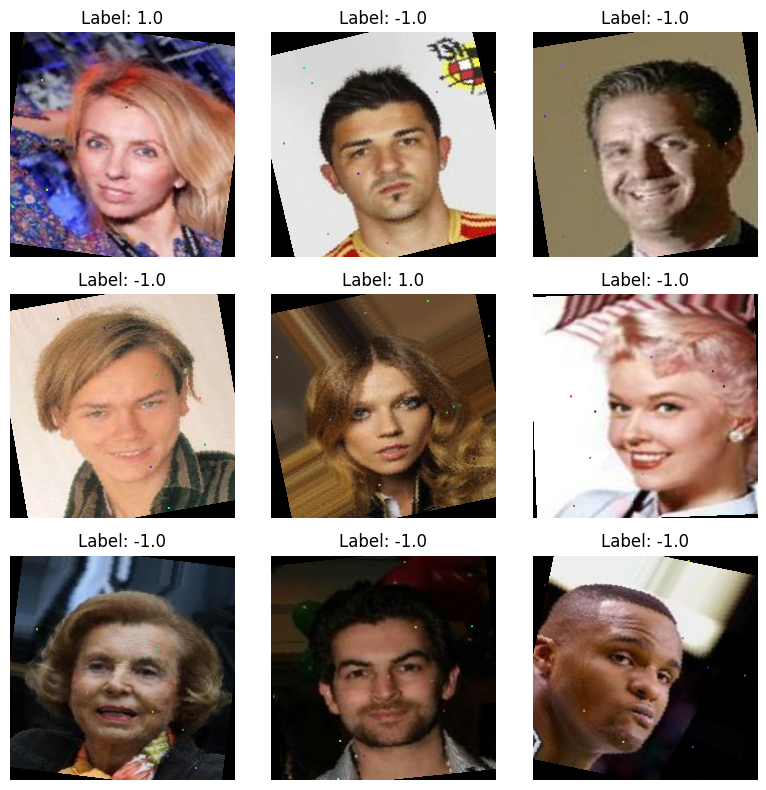

In [19]:
plow_sample(train_tfms)

In [20]:
train_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    AddRandomSquarePIL(count=10, size=2),   
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [21]:
BATCH_SIZE = 128
NUM_EPOCHS = 30

In [22]:
train_ds = MakeupDataset(X_train, y_train, DATA_DIR, transform=train_tfms)
val_ds   = MakeupDataset(X_val,   y_val,   DATA_DIR, transform=val_tfms)
test_ds  = MakeupDataset(X_test,  y_test,  DATA_DIR, transform=val_tfms)

# train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=6)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=6)

val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=6)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=6)

In [23]:
fabric = Fabric(accelerator='cuda', devices=1, precision="bf16-true")
# fabric = Fabric(accelerator="cuda", devices=1, precision="16-mixed")

fabric.launch()
train_loader, test_loader = fabric.setup_dataloaders(train_loader, test_loader)
criterion = nn.BCEWithLogitsLoss()

In [27]:
LR = 0.0001

BEST_MODEL_PATH = 'models/best_alexnet_pixels.pth'

# weight = AlexNet_Weights.IMAGENET1K_V1
# model = models.alexnet(weights=weight)
model = models.alexnet()
model.classifier[6] = nn.Linear(4096, 1) 
model = model.to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR)

model, optimizer = fabric.setup(model, optimizer)

In [25]:
best_f1 = 0.0
history = {'train_loss':[], 'train_f1':[], 'val_loss':[], 'val_f1':[]}

try:
    for epoch in range(1, 30):
        tr_loss, tr_f1 = train_one_epoch(epoch, model)
        val_loss, val_f1, _, _ = eval_model(val_loader, model, 'Validation')
    
        history['train_loss'].append(tr_loss)
        history['train_f1'].append(tr_f1)
        history['val_loss'].append(val_loss)
        history['val_f1'].append(val_f1)
    
        # Сохранение лучшей модели
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, BEST_MODEL_PATH)
            print(f">>> New best model saved (F1={best_f1:.4f})")
except KeyboardInterrupt:
    pass

Train 1: 100%|██████████████████████████████████████████████████████████████████████| 1272/1272 [01:22<00:00, 15.38it/s]


Validation — Loss: 0.2241, F1: 0.8773
>>> New best model saved (F1=0.8773)


Train 2: 100%|██████████████████████████████████████████████████████████████████████| 1272/1272 [01:21<00:00, 15.61it/s]


Validation — Loss: 0.2147, F1: 0.8815
>>> New best model saved (F1=0.8815)


Train 3: 100%|██████████████████████████████████████████████████████████████████████| 1272/1272 [01:21<00:00, 15.61it/s]


Validation — Loss: 0.2085, F1: 0.8865
>>> New best model saved (F1=0.8865)


Train 4: 100%|██████████████████████████████████████████████████████████████████████| 1272/1272 [01:21<00:00, 15.56it/s]


Validation — Loss: 0.2102, F1: 0.8870
>>> New best model saved (F1=0.8870)


Train 5: 100%|██████████████████████████████████████████████████████████████████████| 1272/1272 [01:21<00:00, 15.62it/s]


Validation — Loss: 0.2041, F1: 0.8892
>>> New best model saved (F1=0.8892)


Train 6: 100%|██████████████████████████████████████████████████████████████████████| 1272/1272 [01:22<00:00, 15.47it/s]


Validation — Loss: 0.1982, F1: 0.8890


Train 7: 100%|██████████████████████████████████████████████████████████████████████| 1272/1272 [01:22<00:00, 15.44it/s]


Validation — Loss: 0.1961, F1: 0.8902
>>> New best model saved (F1=0.8902)


Train 8: 100%|██████████████████████████████████████████████████████████████████████| 1272/1272 [01:22<00:00, 15.49it/s]


Validation — Loss: 0.1967, F1: 0.8904
>>> New best model saved (F1=0.8904)


Train 9: 100%|██████████████████████████████████████████████████████████████████████| 1272/1272 [01:21<00:00, 15.54it/s]


Validation — Loss: 0.1998, F1: 0.8905
>>> New best model saved (F1=0.8905)


Train 10: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [01:22<00:00, 15.44it/s]


Validation — Loss: 0.1922, F1: 0.8924
>>> New best model saved (F1=0.8924)


Train 11: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [01:21<00:00, 15.51it/s]


Validation — Loss: 0.1924, F1: 0.8932
>>> New best model saved (F1=0.8932)


Train 12: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [01:21<00:00, 15.53it/s]


Validation — Loss: 0.1931, F1: 0.8928


Train 13: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [01:22<00:00, 15.48it/s]


Validation — Loss: 0.1987, F1: 0.8914


Train 14: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [01:22<00:00, 15.46it/s]


Validation — Loss: 0.1963, F1: 0.8929


Train 15: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [01:22<00:00, 15.44it/s]


Validation — Loss: 0.1916, F1: 0.8943
>>> New best model saved (F1=0.8943)


Train 16: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [01:22<00:00, 15.45it/s]


Validation — Loss: 0.1914, F1: 0.8937


Train 17: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [01:22<00:00, 15.43it/s]


Validation — Loss: 0.1910, F1: 0.8927


Train 18: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [01:22<00:00, 15.48it/s]


Validation — Loss: 0.1894, F1: 0.8904


Train 19: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [01:22<00:00, 15.49it/s]


Validation — Loss: 0.1899, F1: 0.8904


Train 20: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [01:22<00:00, 15.51it/s]


Validation — Loss: 0.1948, F1: 0.8931


Train 21: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [01:22<00:00, 15.37it/s]


Validation — Loss: 0.1939, F1: 0.8944
>>> New best model saved (F1=0.8944)


Train 22: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [01:22<00:00, 15.49it/s]


Validation — Loss: 0.1895, F1: 0.8949
>>> New best model saved (F1=0.8949)


Train 23: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [01:22<00:00, 15.41it/s]


Validation — Loss: 0.1967, F1: 0.8915


Train 24: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [01:22<00:00, 15.41it/s]


Validation — Loss: 0.1889, F1: 0.8962
>>> New best model saved (F1=0.8962)


Train 25: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [01:22<00:00, 15.37it/s]


Validation — Loss: 0.1906, F1: 0.8930


Train 26: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [01:22<00:00, 15.39it/s]


Validation — Loss: 0.1944, F1: 0.8954


Train 27: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [01:22<00:00, 15.35it/s]


Validation — Loss: 0.1916, F1: 0.8873


Train 28: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [01:22<00:00, 15.44it/s]


Validation — Loss: 0.1904, F1: 0.8934


Train 29: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [01:22<00:00, 15.48it/s]


Validation — Loss: 0.1884, F1: 0.8956


In [26]:
print("\n=== Testing on best model ===")
model.load_state_dict(torch.load(BEST_MODEL_PATH))
test_loss, test_f1, y_true, y_pred = eval_model(test_loader, model, 'Test')
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))


=== Testing on best model ===
Test — Loss: 0.2090, F1: 0.8871

Classification Report:
               precision    recall  f1-score   support

           0     0.9337    0.9076    0.9205     11878
           1     0.8695    0.9054    0.8871      8084

    accuracy                         0.9067     19962
   macro avg     0.9016    0.9065    0.9038     19962
weighted avg     0.9077    0.9067    0.9070     19962



## Results

In [24]:
import seaborn as sns
metrics = {
    'Accuracy': [0.9121, 0.9086, 0.9077, 0.9069, 0.9067, 0.9061, 0.9059, 0.9033, 0.9007],
}

models = ["Pretrain", "BatchNorm", "Original", "11x1 and 1x11", "Add pixels", "SiLU", "Dropout=0.8", "1x1", "Scip-connections"]

/tmp/ipykernel_2656/2689889910.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=metrics['Accuracy'], ax=ax_accuracy, palette='Blues_d')


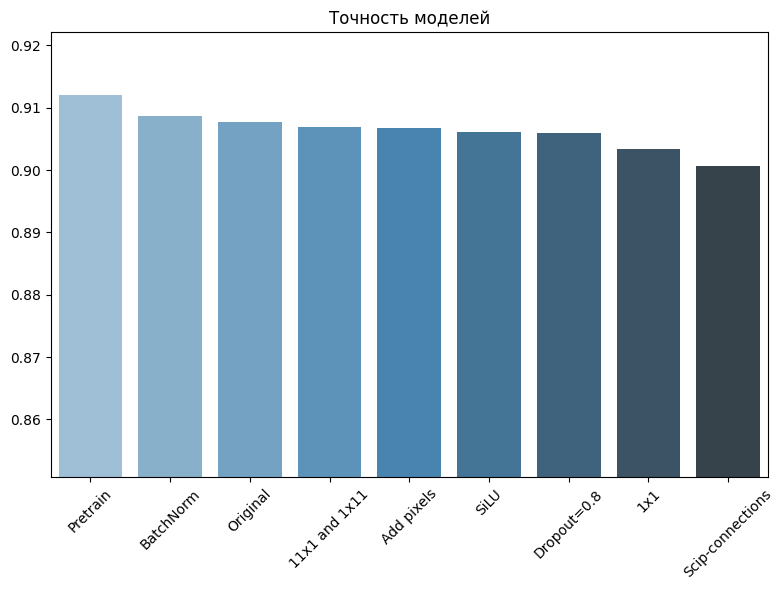

In [27]:
fig_accuracy, ax_accuracy = plt.subplots(figsize=(8, 6))

sns.barplot(x=models, y=metrics['Accuracy'], ax=ax_accuracy, palette='Blues_d')
ax_accuracy.set_title('Точность моделей')
ax_accuracy.tick_params(axis='x', labelrotation=45)
ax_accuracy.set_ylim([min(metrics['Accuracy']) - 0.05, max(metrics['Accuracy']) + 0.01]) # Narrow the range to show differences more clearly
fig_accuracy.tight_layout()

# ResNet

## ResNet original

In [16]:
BATCH_SIZE = 128
NUM_EPOCHS = 30

In [17]:
train_ds = MakeupDataset(X_train, y_train, DATA_DIR, transform=train_tfms)
val_ds   = MakeupDataset(X_val,   y_val,   DATA_DIR, transform=val_tfms)
test_ds  = MakeupDataset(X_test,  y_test,  DATA_DIR, transform=val_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=6)

val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=6)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=6)

In [18]:
fabric = Fabric(accelerator='cuda', devices=1, precision="bf16-true")

fabric.launch()
train_loader, test_loader = fabric.setup_dataloaders(train_loader, test_loader)
criterion = nn.BCEWithLogitsLoss()

In [19]:
LR = 0.001

BEST_MODEL_PATH = 'models/best_resnet18_2.pth'

model = models.resnet18()
model.fc = nn.Linear(512, 1)
model.load_state_dict(torch.load(BEST_MODEL_PATH))
model = model.to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.5)

model, optimizer = fabric.setup(model, optimizer)

In [ ]:
best_f1 = 0.0
history = {'train_loss':[], 'train_f1':[], 'val_loss':[], 'val_f1':[]}

try:
    for epoch in range(1, NUM_EPOCHS):
        tr_loss, tr_f1 = train_one_epoch(epoch, model)
        scheduler.step()
        val_loss, val_f1, _, _ = eval_model(val_loader, model, 'Validation')
    
        history['train_loss'].append(tr_loss)
        history['train_f1'].append(tr_f1)
        history['val_loss'].append(val_loss)
        history['val_f1'].append(val_f1)
    
        # Сохранение лучшей модели
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, BEST_MODEL_PATH)
            print(f">>> New best model saved (F1={best_f1:.4f})")
except KeyboardInterrupt:
    pass

Train 1: 100%|██████████████████████████████████████████████████████████████████████| 1272/1272 [03:09<00:00,  6.73it/s]


Validation — Loss: 0.2384, F1: 0.8757
>>> New best model saved (F1=0.8757)


Train 2: 100%|██████████████████████████████████████████████████████████████████████| 1272/1272 [03:10<00:00,  6.69it/s]


Validation — Loss: 0.2038, F1: 0.8777
>>> New best model saved (F1=0.8777)


Train 3: 100%|██████████████████████████████████████████████████████████████████████| 1272/1272 [03:09<00:00,  6.71it/s]


Validation — Loss: 0.1912, F1: 0.8914
>>> New best model saved (F1=0.8914)


Train 4: 100%|██████████████████████████████████████████████████████████████████████| 1272/1272 [03:09<00:00,  6.71it/s]


Validation — Loss: 0.2483, F1: 0.8210


Train 5: 100%|██████████████████████████████████████████████████████████████████████| 1272/1272 [03:09<00:00,  6.71it/s]


Validation — Loss: 0.2091, F1: 0.8670


Train 6: 100%|██████████████████████████████████████████████████████████████████████| 1272/1272 [03:09<00:00,  6.70it/s]


Validation — Loss: 0.3570, F1: 0.8623


Train 7: 100%|██████████████████████████████████████████████████████████████████████| 1272/1272 [03:09<00:00,  6.72it/s]


Validation — Loss: 0.1829, F1: 0.8862


Train 8: 100%|██████████████████████████████████████████████████████████████████████| 1272/1272 [03:09<00:00,  6.71it/s]


Validation — Loss: 0.1691, F1: 0.9015
>>> New best model saved (F1=0.9015)


Train 9: 100%|██████████████████████████████████████████████████████████████████████| 1272/1272 [03:09<00:00,  6.70it/s]


Validation — Loss: 0.1861, F1: 0.8836


Train 10: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [03:09<00:00,  6.71it/s]


Validation — Loss: 0.1733, F1: 0.8995


Train 11: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [03:09<00:00,  6.72it/s]


Validation — Loss: 0.1892, F1: 0.9002


Train 12: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [03:09<00:00,  6.70it/s]


Validation — Loss: 0.1705, F1: 0.9014


Train 13: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [03:09<00:00,  6.71it/s]


Validation — Loss: 0.1659, F1: 0.9044
>>> New best model saved (F1=0.9044)


Train 14: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [03:09<00:00,  6.70it/s]


Validation — Loss: 0.1725, F1: 0.9036


Train 15:   1%|▋                                                                      | 13/1272 [00:02<03:07,  6.71it/s]

In [20]:
print("\n=== Testing on best model ===")
model.load_state_dict(torch.load(BEST_MODEL_PATH))
test_loss, test_f1, y_true, y_pred = eval_model(test_loader, model, 'Test')
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))


=== Testing on best model ===
Test — Loss: 0.1899, F1: 0.8956

Classification Report:
               precision    recall  f1-score   support

           0     0.9261    0.9331    0.9296     11878
           1     0.9006    0.8906    0.8956      8084

    accuracy                         0.9159     19962
   macro avg     0.9133    0.9119    0.9126     19962
weighted avg     0.9158    0.9159    0.9158     19962



## ResNet pretrain

In [17]:
BATCH_SIZE = 128
NUM_EPOCHS = 30

In [18]:
train_ds = MakeupDataset(X_train, y_train, DATA_DIR, transform=train_tfms)
val_ds   = MakeupDataset(X_val,   y_val,   DATA_DIR, transform=val_tfms)
test_ds  = MakeupDataset(X_test,  y_test,  DATA_DIR, transform=val_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=6)

val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=6)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=6)

In [19]:
fabric = Fabric(accelerator='cuda', devices=1, precision="bf16-true")

fabric.launch()
train_loader, test_loader = fabric.setup_dataloaders(train_loader, test_loader)
criterion = nn.BCEWithLogitsLoss()

In [20]:
LR = 0.001

BEST_MODEL_PATH = 'models/best_resnet18_pretrain.pth'

weight = models.ResNet18_Weights
model = models.resnet18(weights=weight)
model.fc = nn.Linear(512, 1)
model.load_state_dict(torch.load(BEST_MODEL_PATH))
model = model.to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.5)

model, optimizer = fabric.setup(model, optimizer)

In [21]:
best_f1 = 0.0
history = {'train_loss':[], 'train_f1':[], 'val_loss':[], 'val_f1':[]}

try:
    for epoch in range(1, NUM_EPOCHS):
        tr_loss, tr_f1 = train_one_epoch(epoch, model)
        scheduler.step()
        val_loss, val_f1, _, _ = eval_model(val_loader, model, 'Validation')
    
        history['train_loss'].append(tr_loss)
        history['train_f1'].append(tr_f1)
        history['val_loss'].append(val_loss)
        history['val_f1'].append(val_f1)
    
        # Сохранение лучшей модели
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, BEST_MODEL_PATH)
            print(f">>> New best model saved (F1={best_f1:.4f})")
except KeyboardInterrupt:
    pass

Train 1: 100%|██████████████████████████████| 1272/1272 [03:13<00:00,  6.57it/s]


Validation — Loss: 0.1872, F1: 0.8973
>>> New best model saved (F1=0.8973)


Train 2: 100%|██████████████████████████████| 1272/1272 [03:15<00:00,  6.49it/s]


Validation — Loss: 0.1864, F1: 0.8990
>>> New best model saved (F1=0.8990)


Train 3: 100%|██████████████████████████████| 1272/1272 [03:16<00:00,  6.47it/s]


Validation — Loss: 0.1670, F1: 0.9042
>>> New best model saved (F1=0.9042)


Train 4: 100%|██████████████████████████████| 1272/1272 [03:16<00:00,  6.48it/s]


Validation — Loss: 0.1644, F1: 0.9060
>>> New best model saved (F1=0.9060)


Train 5: 100%|██████████████████████████████| 1272/1272 [03:16<00:00,  6.46it/s]


Validation — Loss: 0.1675, F1: 0.9033


Train 6: 100%|██████████████████████████████| 1272/1272 [03:16<00:00,  6.49it/s]


Validation — Loss: 0.2438, F1: 0.8279


Train 7: 100%|██████████████████████████████| 1272/1272 [03:16<00:00,  6.46it/s]


Validation — Loss: 0.1617, F1: 0.9078
>>> New best model saved (F1=0.9078)


Train 8: 100%|██████████████████████████████| 1272/1272 [03:16<00:00,  6.47it/s]


Validation — Loss: 0.1632, F1: 0.9059


Train 9: 100%|██████████████████████████████| 1272/1272 [03:17<00:00,  6.44it/s]


Validation — Loss: 0.1652, F1: 0.9061


Train 10: 100%|█████████████████████████████| 1272/1272 [03:16<00:00,  6.47it/s]


Validation — Loss: 0.1808, F1: 0.8944


Train 11: 100%|█████████████████████████████| 1272/1272 [03:17<00:00,  6.43it/s]


Validation — Loss: 0.1743, F1: 0.9057


Train 12: 100%|█████████████████████████████| 1272/1272 [03:16<00:00,  6.49it/s]


Validation — Loss: 0.1771, F1: 0.9016


Train 13: 100%|█████████████████████████████| 1272/1272 [03:17<00:00,  6.45it/s]


Validation — Loss: 0.1809, F1: 0.9013


Train 14: 100%|█████████████████████████████| 1272/1272 [03:16<00:00,  6.48it/s]


Validation — Loss: 0.1851, F1: 0.9031


Train 15: 100%|█████████████████████████████| 1272/1272 [03:15<00:00,  6.49it/s]


Validation — Loss: 0.1862, F1: 0.9029


Train 16: 100%|█████████████████████████████| 1272/1272 [03:16<00:00,  6.49it/s]


Validation — Loss: 0.1901, F1: 0.8990


Train 17: 100%|█████████████████████████████| 1272/1272 [03:17<00:00,  6.44it/s]


Validation — Loss: 0.1976, F1: 0.8965


Train 18: 100%|█████████████████████████████| 1272/1272 [03:16<00:00,  6.49it/s]


Validation — Loss: 0.1962, F1: 0.8985


Train 19: 100%|█████████████████████████████| 1272/1272 [03:16<00:00,  6.49it/s]


Validation — Loss: 0.2011, F1: 0.8988


Train 20: 100%|█████████████████████████████| 1272/1272 [03:16<00:00,  6.46it/s]


Validation — Loss: 0.2002, F1: 0.8964


Train 21: 100%|█████████████████████████████| 1272/1272 [03:16<00:00,  6.48it/s]


Validation — Loss: 0.2028, F1: 0.8980


Train 22: 100%|█████████████████████████████| 1272/1272 [03:16<00:00,  6.47it/s]


Validation — Loss: 0.2011, F1: 0.8979


Train 23: 100%|█████████████████████████████| 1272/1272 [03:16<00:00,  6.46it/s]


Validation — Loss: 0.2024, F1: 0.8965


Train 24: 100%|█████████████████████████████| 1272/1272 [03:16<00:00,  6.47it/s]


Validation — Loss: 0.2044, F1: 0.8970


Train 25: 100%|█████████████████████████████| 1272/1272 [03:17<00:00,  6.45it/s]


Validation — Loss: 0.2048, F1: 0.8969


Train 26: 100%|█████████████████████████████| 1272/1272 [03:15<00:00,  6.50it/s]


Validation — Loss: 0.2063, F1: 0.8984


Train 27: 100%|█████████████████████████████| 1272/1272 [03:15<00:00,  6.50it/s]


Validation — Loss: 0.2061, F1: 0.8981


Train 28: 100%|█████████████████████████████| 1272/1272 [03:15<00:00,  6.51it/s]


Validation — Loss: 0.2057, F1: 0.8959


Train 29: 100%|█████████████████████████████| 1272/1272 [03:15<00:00,  6.52it/s]


Validation — Loss: 0.2071, F1: 0.8975


In [21]:
print("\n=== Testing on best model ===")
model.load_state_dict(torch.load(BEST_MODEL_PATH))
test_loss, test_f1, y_true, y_pred = eval_model(test_loader, model, 'Test')
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))


=== Testing on best model ===
Test — Loss: 0.1841, F1: 0.9009

Classification Report:
               precision    recall  f1-score   support

           0     0.9337    0.9310    0.9323     11878
           1     0.8990    0.9029    0.9009      8084

    accuracy                         0.9196     19962
   macro avg     0.9164    0.9169    0.9166     19962
weighted avg     0.9197    0.9196    0.9196     19962



## ResNet with SiLU

In [16]:
BATCH_SIZE = 128
NUM_EPOCHS = 30

In [17]:
train_ds = MakeupDataset(X_train, y_train, DATA_DIR, transform=train_tfms)
val_ds   = MakeupDataset(X_val,   y_val,   DATA_DIR, transform=val_tfms)
test_ds  = MakeupDataset(X_test,  y_test,  DATA_DIR, transform=val_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=6)

val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=6)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=6)

In [18]:
fabric = Fabric(accelerator='cuda', devices=1, precision="bf16-true")

fabric.launch()
train_loader, test_loader = fabric.setup_dataloaders(train_loader, test_loader)
criterion = nn.BCEWithLogitsLoss()

In [20]:
LR = 0.001

BEST_MODEL_PATH = 'models/best_resnet_silu.pth'

model = resnet18()
model.fc = nn.Linear(512, 1)
model = model.to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.5)

model, optimizer = fabric.setup(model, optimizer)

In [21]:
best_f1 = 0.0
history = {'train_loss':[], 'train_f1':[], 'val_loss':[], 'val_f1':[]}

try:
    for epoch in range(1, NUM_EPOCHS):
        tr_loss, tr_f1 = train_one_epoch(epoch, model)
        scheduler.step()
        val_loss, val_f1, _, _ = eval_model(val_loader, model, 'Validation')
    
        history['train_loss'].append(tr_loss)
        history['train_f1'].append(tr_f1)
        history['val_loss'].append(val_loss)
        history['val_f1'].append(val_f1)
    
        # Сохранение лучшей модели
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, BEST_MODEL_PATH)
            print(f">>> New best model saved (F1={best_f1:.4f})")
except KeyboardInterrupt:
    pass

Train 1: 100%|██████████████████████████████████████████████████████████████████████| 1272/1272 [03:06<00:00,  6.81it/s]


Validation — Loss: 0.2074, F1: 0.8846
>>> New best model saved (F1=0.8846)


Train 2: 100%|██████████████████████████████████████████████████████████████████████| 1272/1272 [03:08<00:00,  6.75it/s]


Validation — Loss: 0.2020, F1: 0.8913
>>> New best model saved (F1=0.8913)


Train 3: 100%|██████████████████████████████████████████████████████████████████████| 1272/1272 [03:08<00:00,  6.73it/s]


Validation — Loss: 0.2769, F1: 0.8701


Train 4: 100%|██████████████████████████████████████████████████████████████████████| 1272/1272 [03:08<00:00,  6.74it/s]


Validation — Loss: 0.1951, F1: 0.8904


Train 5: 100%|██████████████████████████████████████████████████████████████████████| 1272/1272 [03:09<00:00,  6.71it/s]


Validation — Loss: 0.1908, F1: 0.8848


Train 6: 100%|██████████████████████████████████████████████████████████████████████| 1272/1272 [03:09<00:00,  6.70it/s]


Validation — Loss: 0.2110, F1: 0.8598


Train 7: 100%|██████████████████████████████████████████████████████████████████████| 1272/1272 [03:08<00:00,  6.73it/s]


Validation — Loss: 0.1755, F1: 0.9003
>>> New best model saved (F1=0.9003)


Train 8: 100%|██████████████████████████████████████████████████████████████████████| 1272/1272 [03:09<00:00,  6.71it/s]


Validation — Loss: 0.1742, F1: 0.9057
>>> New best model saved (F1=0.9057)


Train 9: 100%|██████████████████████████████████████████████████████████████████████| 1272/1272 [03:09<00:00,  6.72it/s]


Validation — Loss: 0.2116, F1: 0.8952


Train 10: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [03:09<00:00,  6.72it/s]


Validation — Loss: 0.1958, F1: 0.8727


Train 11: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [03:08<00:00,  6.74it/s]


Validation — Loss: 0.2046, F1: 0.8980


Train 12: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [03:09<00:00,  6.71it/s]


Validation — Loss: 0.1735, F1: 0.9004


Train 13: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [03:09<00:00,  6.71it/s]


Validation — Loss: 0.1676, F1: 0.9058
>>> New best model saved (F1=0.9058)


Train 14: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [03:09<00:00,  6.71it/s]


Validation — Loss: 0.1698, F1: 0.9045


Train 15: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [03:09<00:00,  6.71it/s]


Validation — Loss: 0.1705, F1: 0.9059
>>> New best model saved (F1=0.9059)


Train 16: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [03:09<00:00,  6.72it/s]


Validation — Loss: 0.1719, F1: 0.9051


Train 17: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [03:09<00:00,  6.73it/s]


Validation — Loss: 0.1699, F1: 0.9036


Train 18: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [03:09<00:00,  6.70it/s]


Validation — Loss: 0.1772, F1: 0.8951


Train 19: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [03:08<00:00,  6.73it/s]


Validation — Loss: 0.1740, F1: 0.9015


Train 20: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [03:09<00:00,  6.72it/s]


Validation — Loss: 0.1758, F1: 0.9043


Train 21: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [03:09<00:00,  6.70it/s]


Validation — Loss: 0.1780, F1: 0.8983


Train 22: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [03:09<00:00,  6.71it/s]


Validation — Loss: 0.1742, F1: 0.9019


Train 23: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [03:08<00:00,  6.74it/s]


Validation — Loss: 0.1758, F1: 0.9017


Train 24: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [03:09<00:00,  6.70it/s]


Validation — Loss: 0.1760, F1: 0.9019


Train 25: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [03:09<00:00,  6.70it/s]


Validation — Loss: 0.1772, F1: 0.9025


Train 26: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [03:09<00:00,  6.70it/s]


Validation — Loss: 0.1780, F1: 0.9025


Train 27: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [03:09<00:00,  6.71it/s]


Validation — Loss: 0.1778, F1: 0.9010


Train 28: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [03:09<00:00,  6.73it/s]


Validation — Loss: 0.1777, F1: 0.9003


Train 29: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [03:09<00:00,  6.73it/s]


Validation — Loss: 0.1775, F1: 0.9022


In [23]:
print("\n=== Testing on best model ===")
model.load_state_dict(torch.load(BEST_MODEL_PATH))
test_loss, test_f1, y_true, y_pred = eval_model(test_loader, model, 'Test')
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))


=== Testing on best model ===
Test — Loss: 0.1945, F1: 0.8966

Classification Report:
               precision    recall  f1-score   support

           0     0.9290    0.9305    0.9298     11878
           1     0.8977    0.8955    0.8966      8084

    accuracy                         0.9163     19962
   macro avg     0.9133    0.9130    0.9132     19962
weighted avg     0.9163    0.9163    0.9163     19962



## ResNet101

In [16]:
BATCH_SIZE = 128
NUM_EPOCHS = 30

In [17]:
train_ds = MakeupDataset(X_train, y_train, DATA_DIR, transform=train_tfms)
val_ds   = MakeupDataset(X_val,   y_val,   DATA_DIR, transform=val_tfms)
test_ds  = MakeupDataset(X_test,  y_test,  DATA_DIR, transform=val_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=6)

val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=6)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=6)

In [18]:
fabric = Fabric(accelerator='cuda', devices=1, precision="bf16-true")

fabric.launch()
train_loader, test_loader = fabric.setup_dataloaders(train_loader, test_loader)
criterion = nn.BCEWithLogitsLoss()

In [19]:
LR = 0.001

BEST_MODEL_PATH = 'models/best_resnet_101.pth'

model = models.resnet101()
model.fc = nn.Linear(2048, 1)
model = model.to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.5)

model, optimizer = fabric.setup(model, optimizer)

In [20]:
best_f1 = 0.0
history = {'train_loss':[], 'train_f1':[], 'val_loss':[], 'val_f1':[]}

try:
    for epoch in range(1, NUM_EPOCHS):
        tr_loss, tr_f1 = train_one_epoch(epoch, model)
        scheduler.step()
        val_loss, val_f1, _, _ = eval_model(val_loader, model, 'Validation')
    
        history['train_loss'].append(tr_loss)
        history['train_f1'].append(tr_f1)
        history['val_loss'].append(val_loss)
        history['val_f1'].append(val_f1)
    
        # Сохранение лучшей модели
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, BEST_MODEL_PATH)
            print(f">>> New best model saved (F1={best_f1:.4f})")
except KeyboardInterrupt:
    pass

Train 1: 100%|██████████████████████████████████████████████████████████████████████| 1272/1272 [13:07<00:00,  1.62it/s]


Validation — Loss: 0.2281, F1: 0.8709
>>> New best model saved (F1=0.8709)


Train 2: 100%|██████████████████████████████████████████████████████████████████████| 1272/1272 [13:07<00:00,  1.62it/s]


Validation — Loss: 0.2065, F1: 0.8869
>>> New best model saved (F1=0.8869)


Train 3: 100%|██████████████████████████████████████████████████████████████████████| 1272/1272 [13:06<00:00,  1.62it/s]


Validation — Loss: 0.1963, F1: 0.8898
>>> New best model saved (F1=0.8898)


Train 4: 100%|██████████████████████████████████████████████████████████████████████| 1272/1272 [13:09<00:00,  1.61it/s]


Validation — Loss: 0.2234, F1: 0.8869


Train 5: 100%|██████████████████████████████████████████████████████████████████████| 1272/1272 [13:09<00:00,  1.61it/s]


Validation — Loss: 0.2080, F1: 0.8918
>>> New best model saved (F1=0.8918)


Train 6: 100%|██████████████████████████████████████████████████████████████████████| 1272/1272 [13:07<00:00,  1.61it/s]


Validation — Loss: 0.1966, F1: 0.8829


Train 7: 100%|██████████████████████████████████████████████████████████████████████| 1272/1272 [13:09<00:00,  1.61it/s]


Validation — Loss: 0.1882, F1: 0.9004
>>> New best model saved (F1=0.9004)


Train 8: 100%|██████████████████████████████████████████████████████████████████████| 1272/1272 [13:07<00:00,  1.61it/s]


Validation — Loss: 0.1832, F1: 0.8919


Train 9: 100%|██████████████████████████████████████████████████████████████████████| 1272/1272 [13:06<00:00,  1.62it/s]


Validation — Loss: 0.1748, F1: 0.9014
>>> New best model saved (F1=0.9014)


Train 10: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [13:09<00:00,  1.61it/s]


Validation — Loss: 0.1756, F1: 0.8986


Train 11: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [13:09<00:00,  1.61it/s]


Validation — Loss: 0.1786, F1: 0.8955


Train 12: 100%|█████████████████████████████████████████████████████████████████████| 1272/1272 [13:07<00:00,  1.61it/s]


Validation — Loss: 0.1829, F1: 0.8938


Train 13:  34%|████████████████████████                                              | 437/1272 [04:30<08:37,  1.61it/s]


In [21]:
print("\n=== Testing on best model ===")
model.load_state_dict(torch.load(BEST_MODEL_PATH))
test_loss, test_f1, y_true, y_pred = eval_model(test_loader, model, 'Test')
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))


=== Testing on best model ===
Test — Loss: 0.1974, F1: 0.8932

Classification Report:
               precision    recall  f1-score   support

           0     0.9389    0.9108    0.9246     11878
           1     0.8744    0.9129    0.8932      8084

    accuracy                         0.9116     19962
   macro avg     0.9067    0.9118    0.9089     19962
weighted avg     0.9128    0.9116    0.9119     19962



## Results

In [3]:
import seaborn as sns
metrics = {
    'Accuracy': [0.9196, 0.9163, 0.9159, 0.9116],
}

models = ["Pretrain", "SiLU","Original", "ResNet101"]

/tmp/ipykernel_13791/2689889910.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=metrics['Accuracy'], ax=ax_accuracy, palette='Blues_d')


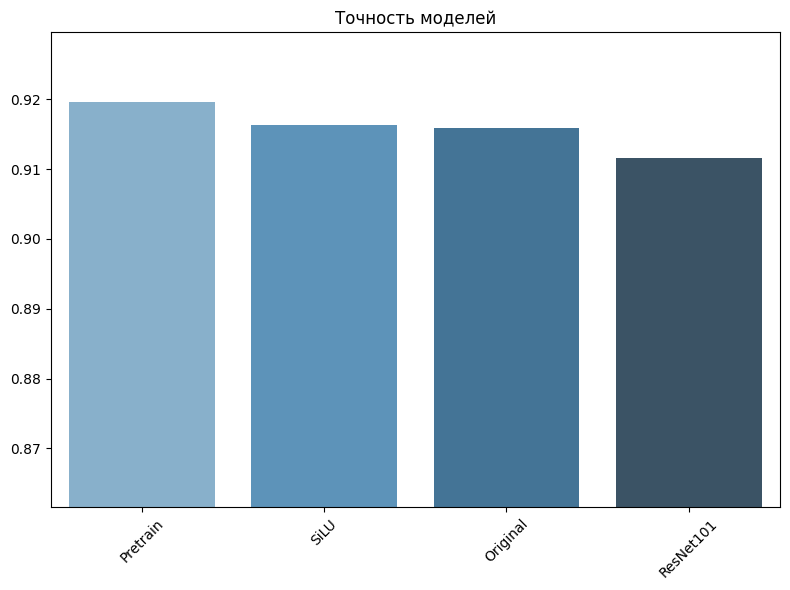

In [4]:
fig_accuracy, ax_accuracy = plt.subplots(figsize=(8, 6))

sns.barplot(x=models, y=metrics['Accuracy'], ax=ax_accuracy, palette='Blues_d')
ax_accuracy.set_title('Точность моделей')
ax_accuracy.tick_params(axis='x', labelrotation=45)
ax_accuracy.set_ylim([min(metrics['Accuracy']) - 0.05, max(metrics['Accuracy']) + 0.01]) # Narrow the range to show differences more clearly
fig_accuracy.tight_layout()